# Name :Vinayak Khanna 
## student id: 24089036
# Name: Hoang Tu Bui 
## student id: 24005665

## The code has been tested and runs without errors.

# Importing the Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.transforms import *
from torch.nn import Hardsigmoid, Hardswish, ReLU, GELU, ELU
from torchsummary import summary
from skimage.feature import hog
from skimage.transform import resize
from torch.autograd import Function
from skimage.color import rgb2gray
from datasets import load_dataset, DatasetDict
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.amp import GradScaler, autocast
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import copy
import optuna
import pandas as pd

#### For `reproducibility` of the notebook, setting up a `seed` for both NumPy and PyTorch.

In [2]:
my_seed = 42
np.random.seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

# Dataset: EuroSAT

The EuroSAT dataset is a comprehensive collection of Sentinel-2 satellite images designed for land use and land cover classification tasks. It consists of 27,000 labeled and geo-referenced images, each with a resolution of 64x64 pixels and has 3 channel.


EuroSAT contain data for 10 classes.

In [3]:
EuroSAT = load_dataset("blanchon/EuroSAT_RGB")
print(EuroSAT)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})


In [4]:
class_mapping = {
    0: "AnnualCrop",
    1: "Forest",
    2: "HerbaceousVegetation",
    3: "Highway",
    4: "Industrial",
    5: "Pasture",
    6: "PermanentCrop",
    7: "Residential",
    8: "River",
    9: "SeaLake",
}

In [5]:
EuroSAT

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})

## lets check some sample image of EuroSAT Dataset

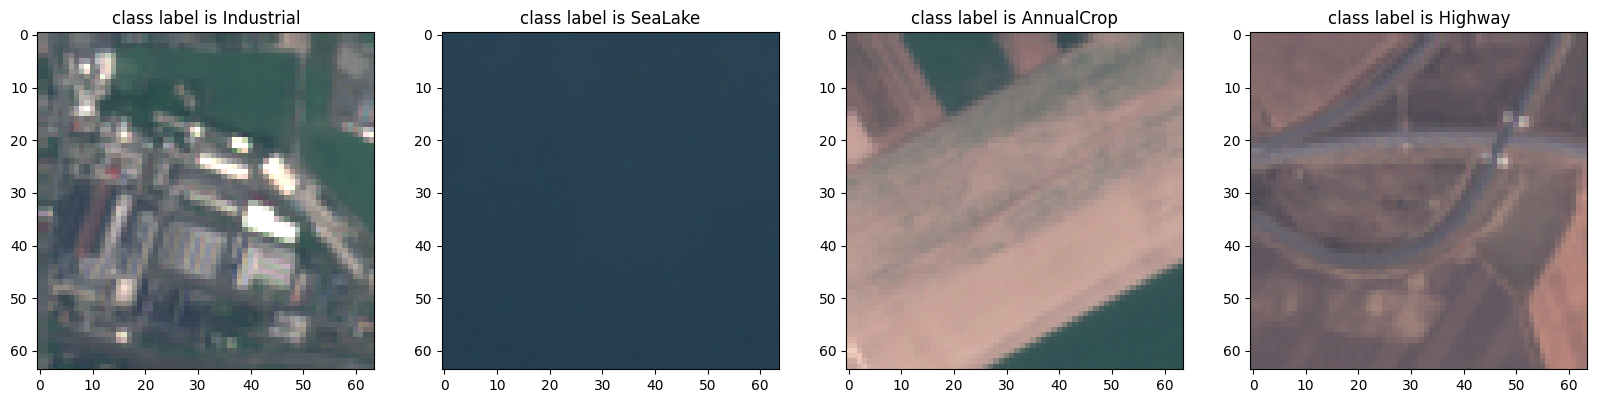

In [6]:
# creating a base transformation for convert PIL image to tensor object and then to a numpy array
to_tensor = transforms.ToTensor()

# helper function to get a sample image from out dataset
img = lambda x: to_tensor(EuroSAT["train"][x]["image"]).permute([1, 2, 0])

# helper function to get the label for that image
label = lambda x: EuroSAT["train"][x]["label"]


plt.figure(figsize=(20, 5))

# generating 4 random numbers
rand_nums = np.random.randint(0, 16200, size=4)

# creating a subplot
for index, i in enumerate(rand_nums):
    plt.subplot(1, 4, index + 1)
    plt.imshow(img(int(i)))
    # converting numerical label to actual label using our class mapping
    plt.title(f"class label is {class_mapping[label(int(i))]}")
plt.show()

### AugmentedDataset: Custom Dataset with Augmentations

The `AugmentedDataset` class is a custom PyTorch dataset that applies random augmentations to images for training. It takes a dictionary containing images and their corresponding labels, and applies a set of augmentations to each image in a controlled manner. This dataset is useful when you want to increase the variability of the data by augmenting images, helping to improve model generalization.


---

In [7]:
class AugmentedDataset(Dataset):
    def __init__(self, data, train_flag=True):
        """
        Initializes the AugmentedDataset.
        Args:
            data (dict): A dictionary containing 'image' and 'label' keys, where:
                         - 'image' is a list of images (PIL images or file paths).
                         - 'label' is a list of corresponding labels.
        """

        self.augmentation_transforms = [
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomRotation(45),
            # RandomAffine(degrees=0, scale=(0.8, 1.2)),
            # RandomResizedCrop(64),  # change as per image size
            # ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        ]

        self.images = [i for i in data["image"]]  # List of images
        self.labels = [i for i in data["label"]]  # List of labels

        self.train_flag = train_flag

        self.augmentations = Compose(
            [
                *self.augmentation_transforms,  # Apply the shuffled augmentations
                Resize((64, 64), antialias=True),  # Resize images to 64x64
                ToTensor(),  # Convert images to PyTorch tensors
            ]
        )

        self.transform = Compose(
            [
                Resize((64, 64), antialias=True),  # Resize images to  64x64
                ToTensor(),  # Convert images to PyTorch tensors
            ]
        )

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.images)  # return

    def __getitem__(self, index):
        """
        Retrieves an image and its corresponding label, applying augmentations if specified.
        Args:
            index (int): Index of the sample to retrieve.
        Returns:
            tuple: A tuple containing the augmented image (tensor) and its label.
        """
        img = self.images[index]
        label = self.labels[index]

        if self.train_flag:
            # Apply transformations
            img = self.augmentations(img)  # Augmented 1
        else:
            # convert to tensor
            img = self.transform(img)

        return img, label

### Creating Train, Test, and Validation Datasets


In [8]:
train_dataset = AugmentedDataset(EuroSAT["train"])
test_dataset = AugmentedDataset(EuroSAT["test"], train_flag=False)
validation_dataset = AugmentedDataset(EuroSAT["validation"], train_flag=False)

In [9]:
len(train_dataset), len(test_dataset), len(validation_dataset)

(16200, 5400, 5400)

In [10]:
# Create DataLoaders for training ,testing and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
validation_loader = DataLoader(validation_dataset, batch_size=64 )

####  Note it is a generally pratice to not use augmentation on test and validation dataset therefore you can notice that only train_dataset has been Augmented whereas the test and validation remain same

## lets check some sample image of Augmentaton trainset

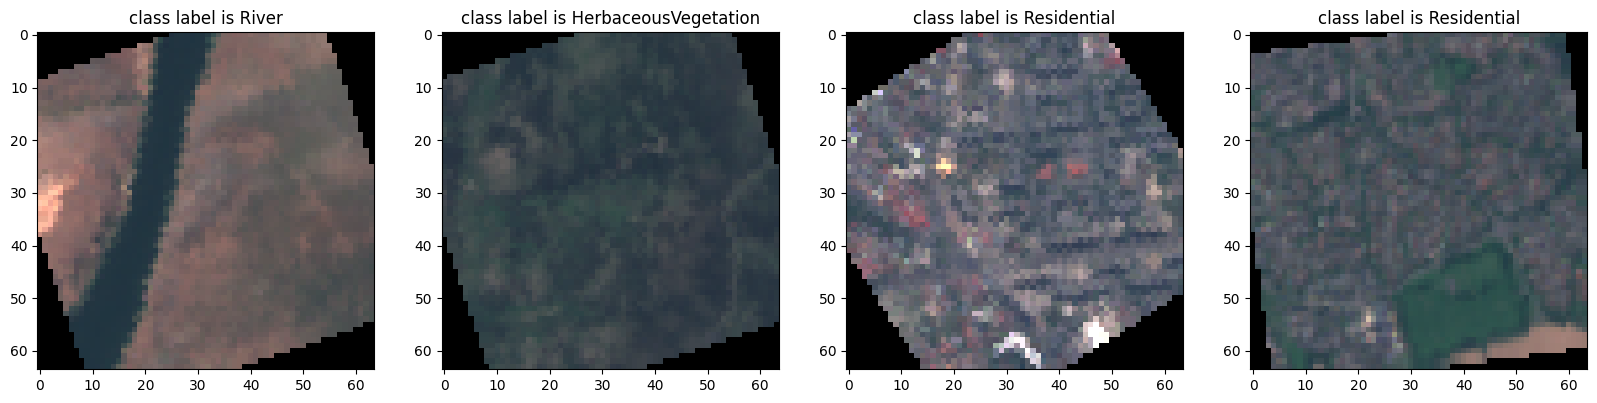

In [11]:
# helper function to get a random sample
img = lambda x: train_dataset[x][0].permute([1, 2, 0])
# helper functoin to get its corresponding label
label = lambda x: train_dataset[x][1]
plt.figure(figsize=(20, 5))
rand_nums = np.random.randint(0, len(train_dataset), size=4)
# creating a subplot
for index, i in enumerate(rand_nums):
    plt.subplot(1, 4, index + 1)
    plt.imshow(img(int(i)))
    plt.title(f"class label is {class_mapping[label(int(i))]}")
plt.show()

## Lets check the distribution of class for all dataset

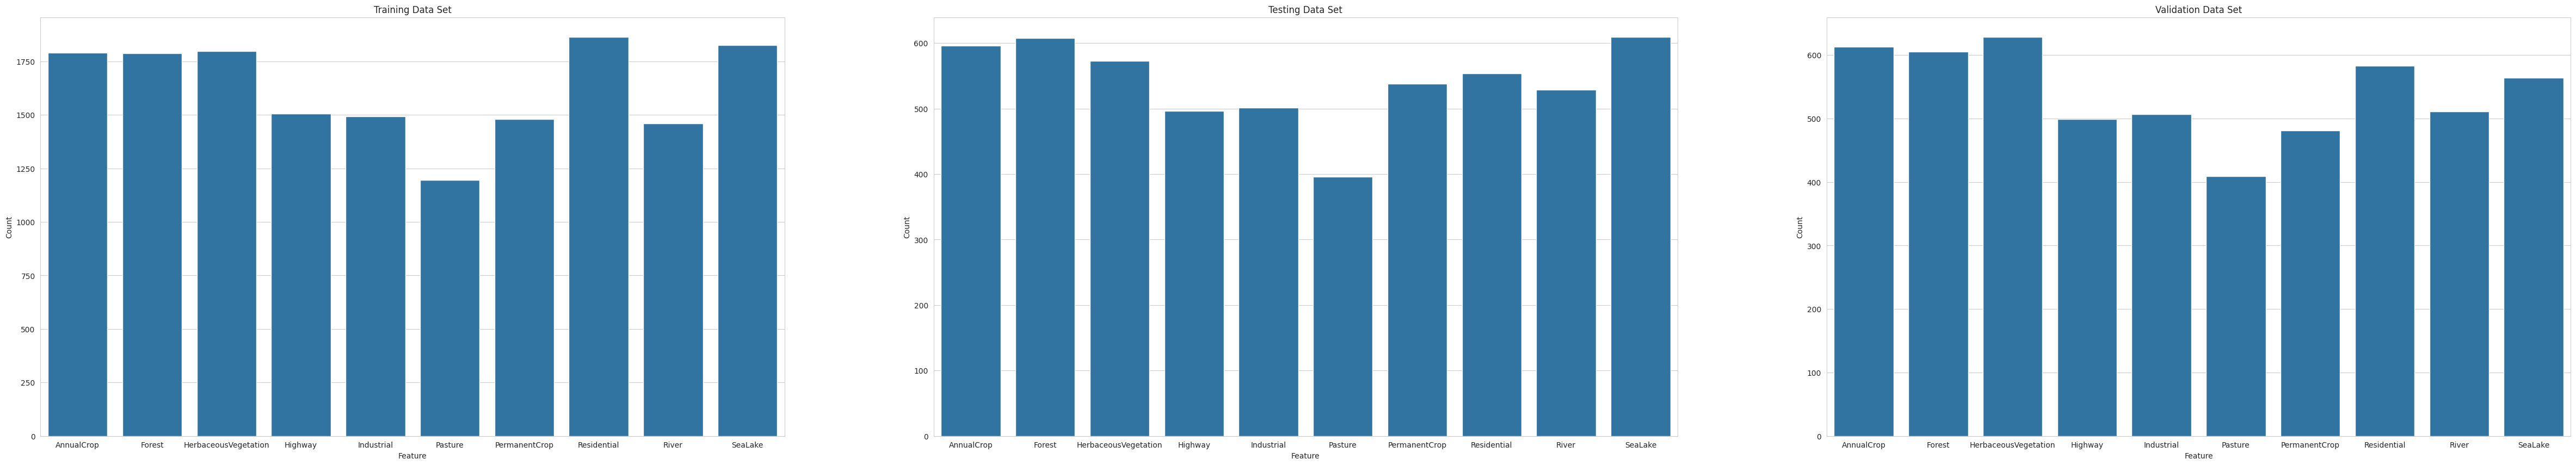

In [12]:
# plotting the distribution of all classes in all 3 dataset
plt.figure(figsize=(60, 10))
sns.set_style("whitegrid")
plt.subplot(1, 3, 1)
plt.title("Training Data Set")
plt.xlabel("Feature")
plt.ylabel("Count")
sns.countplot(x=[class_mapping[label[1]] for label in train_dataset])
plt.subplot(1, 3, 2)
plt.title("Testing Data Set")
plt.xlabel("Feature")
plt.ylabel("Count")
sns.countplot(x=[class_mapping[label[1]] for label in test_dataset])
plt.subplot(1, 3, 3)
plt.title("Validation Data Set")
plt.xlabel("Feature")
plt.ylabel("Count")
sns.countplot(x=[class_mapping[label[1]] for label in validation_dataset])
plt.show()

It seems that all three datasets have the same distribution, so there is no need for feature engineering.

# MobileNet
## Components

we will explore each of the key components of the MobileNet architecture:

### 1. Convolution Block

The **Convolution Block** in MobileNet is responsible for learning local spatial features from the input image. It is the primary operation used in convolutional neural networks (CNNs). MobileNet uses a variant known as **Depthwise Separable Convolutions**.

### 2. Squeeze and Excitation (SE)

The **Squeeze and Excitation (SE) block** is a lightweight mechanism used in MobileNet to improve channel-wise feature recalibration. It works by:
- **Squeeze**: Global average pooling is used to generate a channel descriptor, which captures global information.
- **Excitation**: The channel descriptor is passed through a fully connected (FC) layer followed by a sigmoid activation function to recalibrate the channel weights. This allows the network to focus on important features while suppressing irrelevant ones.

### 3. Bottleneck

The **Bottleneck** is a key architectural component in MobileNet, used to further reduce computational complexity. The bottleneck consists of:
- **Depthwise Separable Convolutions**: As mentioned earlier, these convolutions reduce the number of parameters.
- **Linear Projections**: A sequence of `1x1` convolutions to project the input tensor into a higher dimension, followed by a depthwise convolution to reduce the number of channels.
- **Residual Connections**: These connections are often used to help with training deep models by allowing gradients to flow more easily through the network.


## **Convolutional Block** used in MobileNetV3
Each Convolution block in mobilenetv3 consists of:
- A **Convolution Layer** (`nn.Conv2d`)
- **Batch Normalization** (`nn.BatchNorm2d`)
- An optional **Activation Function** (`e.g., ReLU`)

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_chn, out_chn, activation, kernel_size=3, stride=1, group=1):
        """
        Initializes a Convolutional Block.
        Args:
            in_chn (int): Number of input channels.
            out_chn (int): Number of output channels.
            activation: Activation function to use (e.g., nn.ReLU).
            kernel_size (int): Size of the convolutional kernel. Default is 3.
            stride (int, optional): Stride for the convolution. Default is 1.
            group (int, optional): Number of groups for grouped convolution. Default is 1.
        """

        super().__init__()

        # Calculate padding to maintain spatial dimensions after convolution
        padding = (kernel_size - 1) // 2

        # Define the convolutional layer
        self.conv = nn.Conv2d(
            in_chn,
            out_chn,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
            groups=group,
        )
        # Define the batch normalization layer
        self.bn = nn.BatchNorm2d(out_chn)

        # Define the activation function (if provided)
        self.activate = activation() if activation else None

    def forward(self, x):
        """
        Forward pass for the ConvBlock.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_chn, height, width).
        Returns:
            torch.Tensor: Output tensor after convolution, batch normalization, and activation.
        """

        # Apply convolution
        x = self.conv(x)
        # Apply Batch Normalization
        x = self.bn(x)
        # Apply Activation
        if self.activate is not None:
            x = self.activate(x)
        return x

##  Squeeze-and-Excitation (SE) Block for MobileNet

The **Squeeze-and-Excitation (SE) block** enhances channel-wise feature learning by:
- **Squeezing** spatial dimensions via **Global Average Pooling**.
- **Exciting** importance of channels using **two fully connected layers** and a **non-linearity**.
- **Reweighting** input features via channel-wise multiplication.


In [14]:
class Squeeze_and_Excite(nn.Module):
    def __init__(self, in_chn, reduction=4):
        """
        Initializes a Squeeze-and-Excitation (SE) block.
        Args:
            in_chn (int): Number of input channels.
            reduction (int, optional): Reduction ratio for the intermediate channels. Default is 4.
        """
        super().__init__()

        # Calculate the number of channels after reduction
        reduction_chn = in_chn // reduction

        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(
                1
            ),  # Input: (batch_size, in_chn, H, W) -> Output: (batch_size, in_chn, 1, 1)
            nn.Flatten(),  # Flatten the output to (batch_size, in_chn)
            nn.Linear(
                in_chn, reduction_chn, bias=False
            ),  ## (batch_size, in_chn) -> (batch_size, reduction_chn)
            nn.ReLU(inplace=True),  # Apply ReLU activation
            nn.Linear(
                reduction_chn, in_chn, bias=False
            ),  # # (batch_size, reduction_chn) -> (batch_size, in_chn)
            Hardsigmoid(),  # Apply Hard Sigmoid activation
            nn.Unflatten(
                1, (in_chn, 1, 1)
            ),  ## (batch_size, in_chn) -> (batch_size, in_chn, 1, 1)
        )

    def forward(self, x):
        """
        Forward pass for the Squeeze-and-Excitation block.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_chn, H, W).
        Returns:
            torch.Tensor: Output tensor after applying the SE block.
        """
        # Multiply the input tensor by the channel-wise weights computed by the SE block
        return x * self.se(x)

## Bottleneck Block with Residual Connection and SE (MobileNetV3)

The **Bottleneck block** is the core building unit in **MobileNetV3**, designed for:
- **Depthwise Separable Convolutions**: Reducing computation while maintaining performance.
- **Expansion Layer**: Increasing feature richness before applying depthwise convolution.
- **Squeeze-and-Excitation (SE) Block**: Enhancing important channels.
- **Residual Connections** : Prevent vanishing gradient .

In [15]:
class Bottleneck(nn.Module):
    def __init__(
        self,
        in_chn,
        out_chn,
        expansion_channel,
        activation,
        se_reduction=4,
        se_flag=False,
        kernel=3,
        stride=1,
    ):
        """
        Initializes the Main Block, which consists of a residual block with optional Squeeze-and-Excitation (SE).

        Args:
            in_chn (int): Number of input channels.
            out_chn (int): Number of output channels.
            expansion_channel (int): Number of channels in the expansion layer.
            activation : Activation function to use (e.g., nn.ReLU).
            se_reduction (int, optional): Reduction ratio for the SE block. Default is 4.
            se_flag (bool, optional): Whether to include the SE block. Default is False.
            kernel (int): Kernel size for the depthwise convolution. Default is 3.
            stride (int): Stride for the depthwise convolution. Default is 1.
        """
        super().__init__()

        # Determine if a residual connection should be used
        # Residual connection is used if stride == 1 and input channels == output channels
        self.use_residual = (stride == 1) and (in_chn == out_chn)

        # Define the layers of the residual block

        self.residual_block_layers = [
            # Expansion convolution: 1x1 convolution to expand the number of channels
            ConvBlock(in_chn, expansion_channel, activation=activation, kernel_size=1),
            # Depthwise convolution: Grouped convolution with kernel_size x kernel_size
            ConvBlock(
                expansion_channel,
                expansion_channel,
                activation=activation,
                group=expansion_channel,
                stride=stride,
                kernel_size=kernel,
            ),  # (batch_size, expansion_channel, H, W) -> (batch_size, expansion_channel, H', W')
        ]

        # Add Squeeze-and-Excitation (SE) block if se_flag is True
        if se_flag:

            self.residual_block_layers.extend(
                [
                    Squeeze_and_Excite(
                        expansion_channel, reduction=se_reduction
                    )  # Apply SE to recalibrate channel-wise features
                ]
            )

        # Projection convolution: 1x1 convolution to reduce the number of channels back to out_chn
        self.residual_block_layers.extend(
            [ConvBlock(expansion_channel, out_chn, activation=None, kernel_size=1)]
        )

        # Combine all layers into a sequential module
        self.layers = nn.Sequential(*self.residual_block_layers)

    def forward(self, x):
        """
        Forward pass for the Main Block.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_chn, H, W).
        Returns:
            torch.Tensor: Output tensor after applying the residual block.
        """
        # Apply the residual block layers
        out = self.layers(x)
        # Add the residual connection if conditions are met
        return out + x if self.use_residual else out

## Tradition Feature Extraction: Sobel & HOG
 Before diving into main MobileNet wrapper, let's first look at two additional classes used for computing Sobel and HOG (Histogram of Oriented Gradients) features. These will be used alongside MobileNetV3 to investigate whether traditional image features can improve performance.


### Sobel Feature Extraction

we define a class called `SobelFeatureExtractor`, which applies Sobel filters to extract edge features from an input image. These edge features will be used alongside MobileNetV3 to see if traditional image features can improve the model's performance.

The class uses a convolutional layer to apply the Sobel filters and outputs a tensor with additional channels that represent the gradients in both directions. By adding these edge features to the original image, we aim to provide the model with more informative inputs going from 3 input channel image to 5 input channel image.


In [16]:
class SobelFeatureExtractor(nn.Module):
    def __init__(self):
        """
        Initializes the SobelFeatureExtractor module.

        This module applies Sobel filters to extract edge features from an input image.
        The Sobel filters are used to compute approximate gradients in the horizontal (x)
        and vertical (y) directions, which are useful for edge detection.
        """
        super().__init__()

        # Define a convolutional layer to apply Sobel filters
        # Input: 3 channels (RGB image), Output: 2 channels (gradients in x and y directions)
        self.sobel_conv = nn.Conv2d(3, 2, kernel_size=3, padding=1, bias=False)

        # Define Sobel kernels for horizontal (x) and vertical (y) gradients
        sobel_x = torch.tensor(
            [[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32
        )  # Sobel X kernel
        sobel_y = torch.tensor(
            [[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32
        )  # Sobel Y kernel

        # Stack the Sobel kernels and reshape them to match the convolutional layer's weight format
        self.sobel_conv.weight.data = (
            torch.stack([sobel_x, sobel_y]).unsqueeze(1).repeat(1, 3, 1, 1)
        )

        # Freeze the weights of the Sobel convolution layer to prevent them from being updated during training
        self.sobel_conv.requires_grad_(False)

    def forward(self, x):
        """
        Forward pass for the SobelFeatureExtractor.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W), representing an RGB image.
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 5, H, W), where the additional 2 channels
                          are the Sobel gradients in the x and y directions.
        """
        # Apply the Sobel convolution to compute gradients
        sobel_features = self.sobel_conv(x)
        # Concatenate the original input image with the Sobel features along the channel dimension
        return torch.cat([x, sobel_features], dim=1)

### HOG Feature Extraction

The `HOGFunction` class implements a custom PyTorch function for extracting Histogram of Oriented Gradients (HOG) features from an input image. HOG is a feature descriptor that captures the structure or shape of objects in an image based on the distribution of local gradients.

This function is non-differentiable, meaning gradients will not be calculated during backpropagation, which is why the `backward` method returns `None` for the gradients.


In [17]:
class HOGFunction(Function):

    @staticmethod
    def forward(ctx, input, hog_size=(64, 64), orientations=9, pixels_per_cell=(8, 8)):
        """
        Forward pass for the HOG (Histogram of Oriented Gradients) function.

        Args:
            ctx: Context object to save information for backward pass (not used here).
            input (torch.Tensor): Input tensor of shape (batch_size, 3, H, W), representing RGB images.
            hog_size (tuple, optional): Target size for resizing the image before computing HOG. Default is (64, 64).
            orientations (int, optional): Number of orientation bins for HOG. Default is 9.
            pixels_per_cell (tuple, optional): Size of a cell in pixels for HOG computation. Default is (8, 8).

        Returns:
            torch.Tensor: A tensor of shape (batch_size, hog_feature_dim) containing HOG features for each image.
        """

        device = input.device  # Device of the input tensor (CPU or GPU)
        batch_size = input.shape[0]  # Number of images in the batch
        hog_features = []  # List to store HOG features for each image

        # Process each image in the batch
        for img in input:
            # Convert to numpy
            np_img = img.permute(1, 2, 0).cpu().numpy()
            gray_img = rgb2gray(np_img)  # Convert to grayscale

            # Resize and compute HOG
            resized_img = resize(gray_img, hog_size, anti_aliasing=True)

            # Compute HOG features
            fd = hog(
                resized_img,
                orientations=orientations,  # Number of orientation bins
                pixels_per_cell=pixels_per_cell,  # Size of a cell in pixels
                cells_per_block=(1, 1),  # Number of cells in each block
                feature_vector=True,  # Return features as a single vector
                visualize=False,  # Do not return a visualization image
            )
            # Convert HOG features to a PyTorch tensor and add to the list
            hog_features.append(torch.from_numpy(fd).float())

        # Stack all HOG features into a single tensor and move it to the input device
        return torch.stack(hog_features).to(device)

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass for the HOG function.
        Args:
            ctx: Context object (not used here).
            grad_output (torch.Tensor): Gradient of the loss with respect to the output.
        Returns:
            None: HOGFunction is non-differentiable, so gradients are not computed.
        """
        return None, None, None, None

### HOGLayer: HOG Feature Extraction and Neural Network Processing

The `HOGLayer` class is designed to compute Histogram of Oriented Gradients (HOG) features from input images and then pass these features through a dense neural network for further processing.


In [18]:
class HOGLayer(nn.Module):
    def __init__(self, hog_size=(64, 64), hog_feature_dim=576):
        """
        Initializes the HOGLayer module.
        This module computes HOG features from input images and applies a dense neural network to the features.

        Args:
            hog_size (tuple, optional): Target size for resizing the image before computing HOG. Default is (64, 64).
            hog_feature_dim (int, optional): Dimensionality of the HOG feature vector. Default is 576.
        """
        super().__init__()

        self.hog_size = hog_size  # Target size for resizing images
        self.dense = nn.Sequential(
            nn.Linear(
                hog_feature_dim, 512
            ),  # Fully connected layer to map HOG features to 1024 dimensions
            nn.ReLU6(),  # ReLU6 activation function
            nn.Linear(
                512, 256
            ),  # Fully connected layer to map 1024 dimensions to 512 dimensions
        )

    def forward(self, x):
        """
        Forward pass for the HOGLayer.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W), representing RGB images.
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 256), representing processed HOG features.
        """
        # Compute HOG features using the HOGFunction
        hog_features = HOGFunction.apply(x, self.hog_size)
        # Pass the HOG features through the dense neural network
        return self.dense(hog_features)

## MobileNetV3: Complete Architecture with Hybrid Mode

The `MobileNetV3` class is a full implementation of the MobileNetV3 architecture, supporting:
- **Two Variants**: `large` and `small`, based on the original MobileNetV3 paper.
- **Hybrid Mode (Optional)**: Incorporates **Sobel** and **HOG** feature extraction for enhanced learning.

### **Key Features**
1. **Configurable Depth**: Uses `_get_config(mode)` to define the architecture based on the chosen variant.
2. **Feature Extraction**:
   - Standard: Uses depthwise separable convolutions with **Bottleneck** blocks.
   - Hybrid: Includes **SobelFeatureExtractor** and **HOGLayer** for preprocessing.
3. **Final Classifier**:
   - Standard: Fully connected layers for classification.
   - Hybrid: Combines MobileNet and HOG features before classification.


In [19]:
class MobileNetV3(nn.Module):
    def __init__(
        self,
        in_chn=3,
        se_reduction=4,
        mode="large",
        num_classes=10,
        deep_activation=Hardswish,
        hybrid=False,
    ):
        """
        MobileNetV3 with optional hybrid (Sobel+HOG) mode
        Args:
            in_chn (int): Input channels (3 for RGB, 5 for hybrid mode)
            se_reduction (int): SE block reduction ratio
            mode (str): 'large' or 'small' architecture
            num_classes (int): Output classes
            activation : which activation to be used in Bottleneck layer
            hybrid (bool): Enable hybrid Sobel+HOG mode
        """
        super().__init__()
        self.hybrid = hybrid
        self.mode = mode
        self.se_reduction = se_reduction
        self.deep_activation = deep_activation

        # Initialize feature extractors for hybrid mode
        if self.hybrid:

            self.sobel = (
                SobelFeatureExtractor()
            )  # Outputs 5 channels (RGB+SobelX+SobelY)
            self.hog_layer = HOGLayer()  # HOG feature extractor (Dense layer)

        # Architecture configuration
        self.layers_config, last_channel = self._get_config(mode)

        # Build core MobileNetV3 components
        self.features = self._build_features(in_chn)
        self.final = self._build_final_layers(last_channel, num_classes)

        # Hybrid-specific components
        if self.hybrid:
            self.hog_fc = nn.Linear(512, num_classes)  # 256 MobileNet + 256 HOG

    def _get_config(self, mode):
        """Get layer configuration and final channel count"""
        if mode == "large":
            return (
                [
                    [3, 16, 16, False, ReLU, 1],
                    [3, 64, 24, False, ReLU, 2],
                    [3, 72, 24, False, ReLU, 1],
                    [5, 72, 40, True, ReLU, 2],
                    [5, 120, 40, True, ReLU, 1],
                    [5, 120, 40, True, ReLU, 1],
                    [3, 240, 80, False, self.deep_activation, 2],
                    [3, 200, 80, False, self.deep_activation, 1],
                    [3, 184, 80, False, self.deep_activation, 1],
                    [3, 184, 80, False, self.deep_activation, 1],
                    [3, 480, 112, True, self.deep_activation, 1],
                    [3, 672, 112, True, self.deep_activation, 1],
                    [5, 672, 160, True, self.deep_activation, 2],
                    [5, 960, 160, True, self.deep_activation, 1],
                    [5, 960, 160, True, self.deep_activation, 1],
                ],
                1280,
            )
        else:
            return (
                [
                    [3, 16, 16, True, ReLU, 2],
                    [3, 72, 24, False, ReLU, 2],
                    [3, 88, 24, False, ReLU, 1],
                    [5, 96, 40, True, self.deep_activation, 2],
                    [5, 240, 40, True, self.deep_activation, 1],
                    [5, 240, 40, True, self.deep_activation, 1],
                    [5, 120, 48, True, self.deep_activation, 1],
                    [5, 144, 48, True, self.deep_activation, 1],
                    [5, 288, 96, True, self.deep_activation, 2],
                    [5, 576, 96, True, self.deep_activation, 1],
                    [5, 576, 96, True, self.deep_activation, 1],
                ],
                1024,
            )  # return 2 thing config list and neuron in the last chanbel

    def _build_features(self, in_chn):
        """Construct initial convolutional blocks"""
        features = [
            ConvBlock(in_chn, 16, activation=Hardswish, kernel_size=3, stride=2)
        ]
        input_channel = 16

        # create the bottleneck block based on the config choose
        for kernel, exp, out, se, act, stride in self.layers_config:
            features.append(
                Bottleneck(
                    in_chn=input_channel,
                    out_chn=out,
                    expansion_channel=exp,
                    activation=act,
                    kernel=kernel,
                    se_flag=se,
                    stride=stride,
                    se_reduction=self.se_reduction,
                )
            )
            input_channel = out

        return nn.Sequential(*features)

    def _build_final_layers(self, last_channel, num_classes):
        """Construct final classification blocks"""
        if self.hybrid:

            return nn.Sequential(
                ConvBlock(
                    self.layers_config[-1][2],
                    960 if self.mode == "large" else 576,
                    activation=Hardswish,
                    kernel_size=1,
                ),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(960 if self.mode == "large" else 576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, 256),
            )  # Reduced features for hybrid combination
        else:
            return nn.Sequential(
                ConvBlock(
                    self.layers_config[-1][2],
                    960 if self.mode == "large" else 576,
                    activation=Hardswish,
                    kernel_size=1,
                ),
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(960 if self.mode == "large" else 576, last_channel, 1),
                Hardswish(),
                nn.Flatten(),
                nn.Linear(last_channel, num_classes),
            )  # if we are not using hybrid approach we can directly output

    def forward(self, x):
        if self.hybrid:
            # Process Sobel-augmented image
            sob_x = self.sobel(x)  # (batch, 5, H, W)
            features = self.features(sob_x)
            mobilenet_out = self.final(features)  # (batch, 256)

            # Process HOG features
            hog_features = self.hog_layer(x)  # (batch, 256)

            # Combine features
            combined = torch.cat([mobilenet_out, hog_features], dim=1)
            return self.hog_fc(combined)  # (batch, num_classes)
        else:
            # Standard processing
            x = self.features(x)
            return self.final(x)

# Inference Functions for the Model






In [20]:
def infer(model, device, dataLoader):
    """Infer the predictions.

    Args:
        model (nn.Module): The model to use for inference.
        device (torch.device): The device to use.
        dataLoader (DataLoader): The data to infer.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The predictions and the actual labels.
    """

    model.eval()
    predProba = []
    actual = []
    # no gradient is computed
    with torch.no_grad():
        for inputs, labels in dataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            actual.append(labels)
            predProba.append(outputs)

    return torch.cat(predProba), torch.cat(actual)

# Train Config

In [21]:
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = ", device)
n_epochs = 100
earlyStopping = 15

Device =  cuda


# Training

In [22]:
def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    n_epochs=100,
    earlyStopping=10,
    verbose=True,
):
    """Train the model.

    Args:
        model (nn.Module): The model to train.
        device (torch.device): The device to use.
        trainLoader (DataLoader): The training data.
        valLoader (DataLoader): The validation data.
        criterion (_type_): The loss function.
        optimizer (_type_): The optimizer.
        n_epochs (int, optional): Number of epochs to train for. Defaults to 100.
        earlyStopping (int, optional): Number of epochs to wait before stopping training if no improvement is made
            on the validation loss. Defaults to 10.
    """

    optimScheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.2)
    metrics = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Training loop
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    for epoch in range(n_epochs):
        start_time = time.time()
        trainLoss = 0
        trainAcc = 0
        model.train()

        for batch_idx, (inputs, labels) in enumerate(trainLoader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).float().mean()

            loss.backward()
            optimizer.step()

            trainLoss += loss.item()
            trainAcc += acc.item()

            # Print every 100 batches
            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx}/{len(trainLoader)}], Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}"
                )

        trainLoss /= len(trainLoader)
        trainAcc /= len(trainLoader)

        # Validation loss
        pred, actual = infer(model, device, valLoader)
        valLoss = criterion(pred, actual)
        valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()

        epoch_time = time.time() - start_time

        print(
            f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {trainLoss:.4f}, Val Loss: {valLoss:.4f}, Train Acc: {trainAcc:.4f}, Val Acc: {valAcc:.4f}"
        )
        print(f"Time: {epoch_time//60} min {epoch_time % 60:.2f} sec")
        print("=" * 50)

        metrics["train_loss"].append(trainLoss)
        metrics["train_acc"].append(trainAcc)
        metrics["val_loss"].append(valLoss.item())
        metrics["val_acc"].append(valAcc.item())

        # Early stopping
        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = copy.deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1
            if patience > earlyStopping:
                break

        optimScheduler.step(valLoss)

    # Save the model
    model.load_state_dict(bestModelState)  # type: ignore

    return metrics

### Base MobileNet

In [23]:
base_model = MobileNetV3(in_chn=3, mode="small", num_classes=10, hybrid=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=lr)


In [24]:
%%time
base_history = train(
    model=base_model.to(device),
    device=device,
    trainLoader=train_loader,
    valLoader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    earlyStopping=earlyStopping,
)

Epoch [1/100], Step [0/254], Loss: 2.3340, Accuracy: 0.0469
Epoch [1/100], Step [100/254], Loss: 1.4221, Accuracy: 0.4688
Epoch [1/100], Step [200/254], Loss: 0.9366, Accuracy: 0.6094
Epoch [1/100], Train Loss: 1.2380, Val Loss: 1.1014, Train Acc: 0.5458, Val Acc: 0.6165
Time: 0.0 min 8.64 sec
Epoch [2/100], Step [0/254], Loss: 0.8914, Accuracy: 0.6250
Epoch [2/100], Step [100/254], Loss: 0.7096, Accuracy: 0.7812
Epoch [2/100], Step [200/254], Loss: 0.9708, Accuracy: 0.6562
Epoch [2/100], Train Loss: 0.8586, Val Loss: 0.8125, Train Acc: 0.6899, Val Acc: 0.7256
Time: 0.0 min 8.09 sec
Epoch [3/100], Step [0/254], Loss: 0.6451, Accuracy: 0.7812
Epoch [3/100], Step [100/254], Loss: 0.7758, Accuracy: 0.6875
Epoch [3/100], Step [200/254], Loss: 0.7846, Accuracy: 0.7031
Epoch [3/100], Train Loss: 0.7645, Val Loss: 0.7646, Train Acc: 0.7210, Val Acc: 0.7274
Time: 0.0 min 8.04 sec
Epoch [4/100], Step [0/254], Loss: 0.7813, Accuracy: 0.7188
Epoch [4/100], Step [100/254], Loss: 0.6316, Accuracy: 

In [25]:
%%time
pred, actual = infer(base_model, device, test_loader)
valLoss = criterion(pred, actual)
valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()
print('The accuracy on unseen data is',valAcc.item())

The accuracy on unseen data is 0.9394444227218628
CPU times: user 808 ms, sys: 0 ns, total: 808 ms
Wall time: 807 ms


### Hybrid MobileNet (HoG and Sobel)

In [26]:
# Note in order to run MobileNetv3 hybrid you need to specify input channel as 5 (RGB+sobelx_sobely)
hybrid_model = MobileNetV3(in_chn=5, mode="small", num_classes=10, hybrid=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(hybrid_model.parameters(), lr=lr)

hybrid_history = train(
    model=hybrid_model.to(device),
    device=device,
    trainLoader=train_loader,
    valLoader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    earlyStopping=earlyStopping,
)

Epoch [1/100], Step [0/254], Loss: 2.3238, Accuracy: 0.0469
Epoch [1/100], Step [100/254], Loss: 0.9913, Accuracy: 0.6406
Epoch [1/100], Step [200/254], Loss: 0.6492, Accuracy: 0.7344
Epoch [1/100], Train Loss: 1.2180, Val Loss: 0.9123, Train Acc: 0.5453, Val Acc: 0.6698
Time: 0.0 min 39.44 sec
Epoch [2/100], Step [0/254], Loss: 1.3039, Accuracy: 0.5938
Epoch [2/100], Step [100/254], Loss: 1.1151, Accuracy: 0.6094
Epoch [2/100], Step [200/254], Loss: 1.1234, Accuracy: 0.5938
Epoch [2/100], Train Loss: 0.8124, Val Loss: 0.6979, Train Acc: 0.6992, Val Acc: 0.7524
Time: 0.0 min 39.40 sec
Epoch [3/100], Step [0/254], Loss: 0.9056, Accuracy: 0.6562
Epoch [3/100], Step [100/254], Loss: 0.8193, Accuracy: 0.6250
Epoch [3/100], Step [200/254], Loss: 0.8562, Accuracy: 0.6406
Epoch [3/100], Train Loss: 0.7290, Val Loss: 0.7447, Train Acc: 0.7355, Val Acc: 0.7411
Time: 0.0 min 39.41 sec
Epoch [4/100], Step [0/254], Loss: 0.6169, Accuracy: 0.8125
Epoch [4/100], Step [100/254], Loss: 0.7289, Accurac

In [27]:
%%time
pred, actual = infer(hybrid_model, device, test_loader)
valLoss = criterion(pred, actual)
valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()
print('The accuracy on unseen data is',valAcc.item())

The accuracy on unseen data is 0.9151852130889893
CPU times: user 8.7 s, sys: 3.93 ms, total: 8.71 s
Wall time: 8.7 s


# Evaluation

## Learning Curve

In [28]:
def plotLearningCurve(history, title):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def plotAccuracyCurve(history, title):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### For Base model

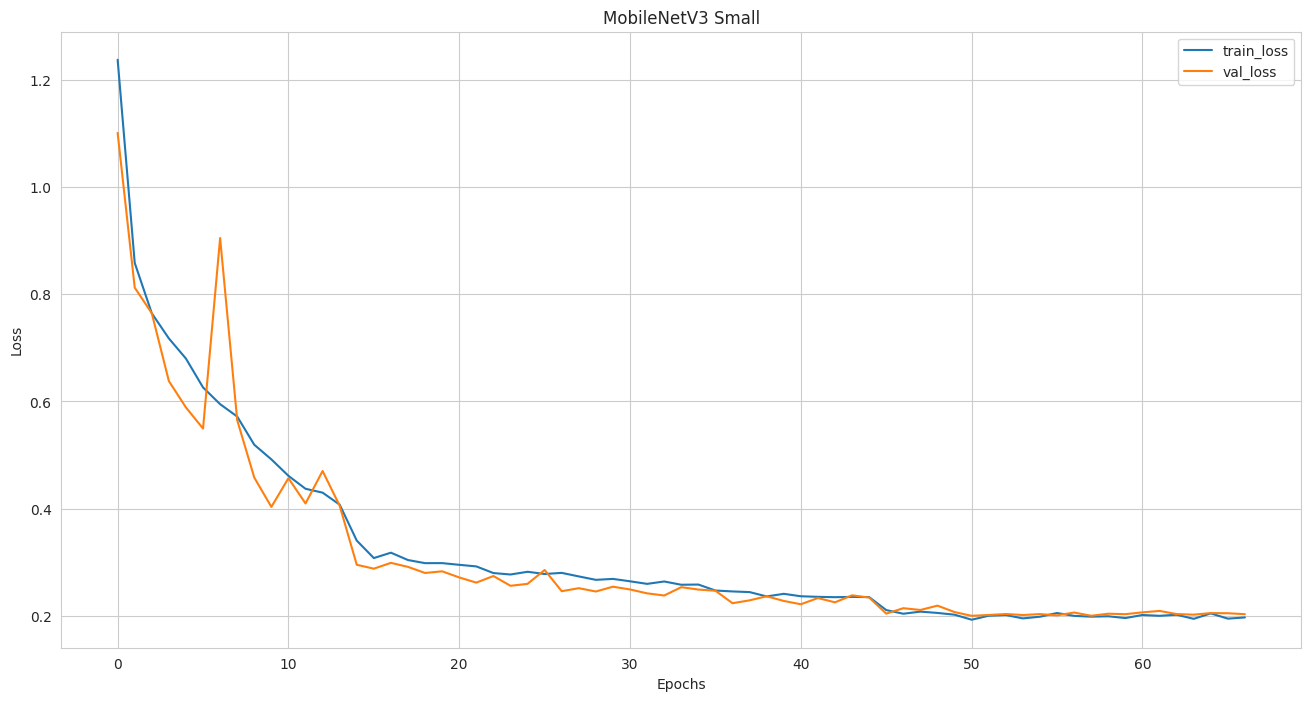

In [29]:
plotLearningCurve(base_history, "MobileNetV3 Small")

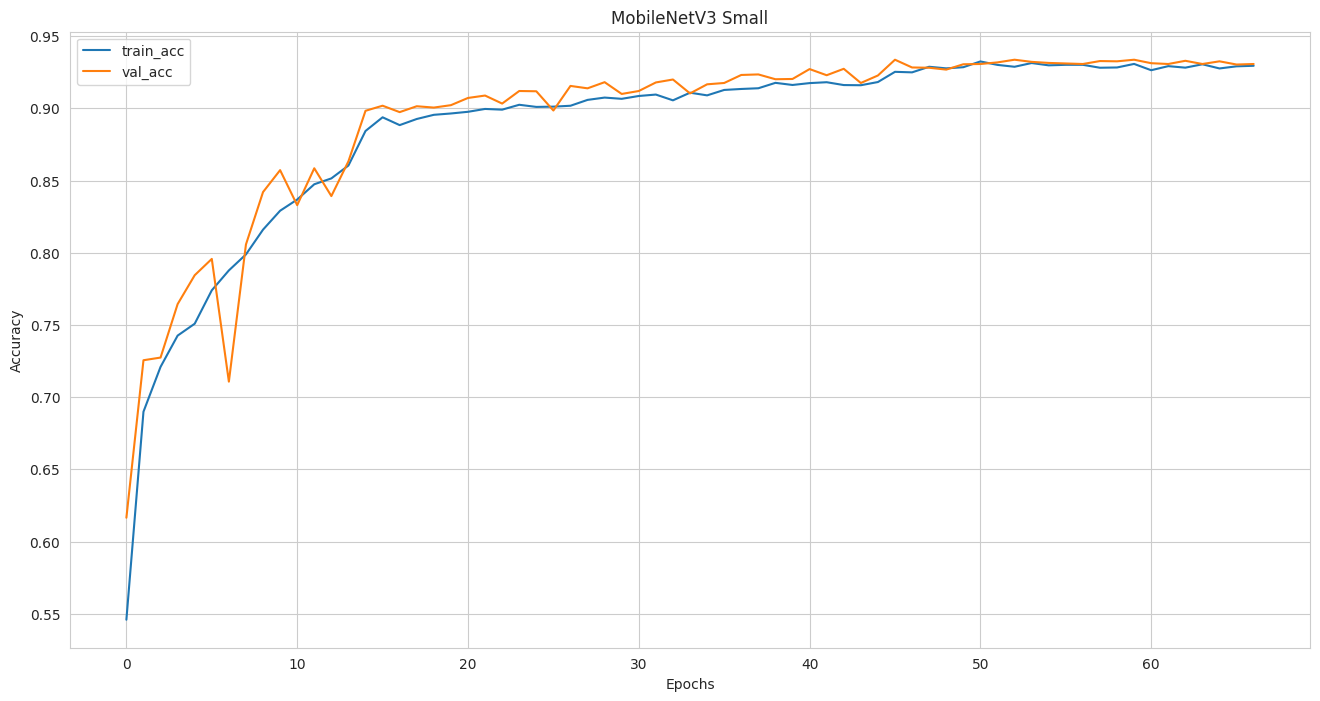

In [30]:
plotAccuracyCurve(base_history, "MobileNetV3 Small")

### For Hybrid Model

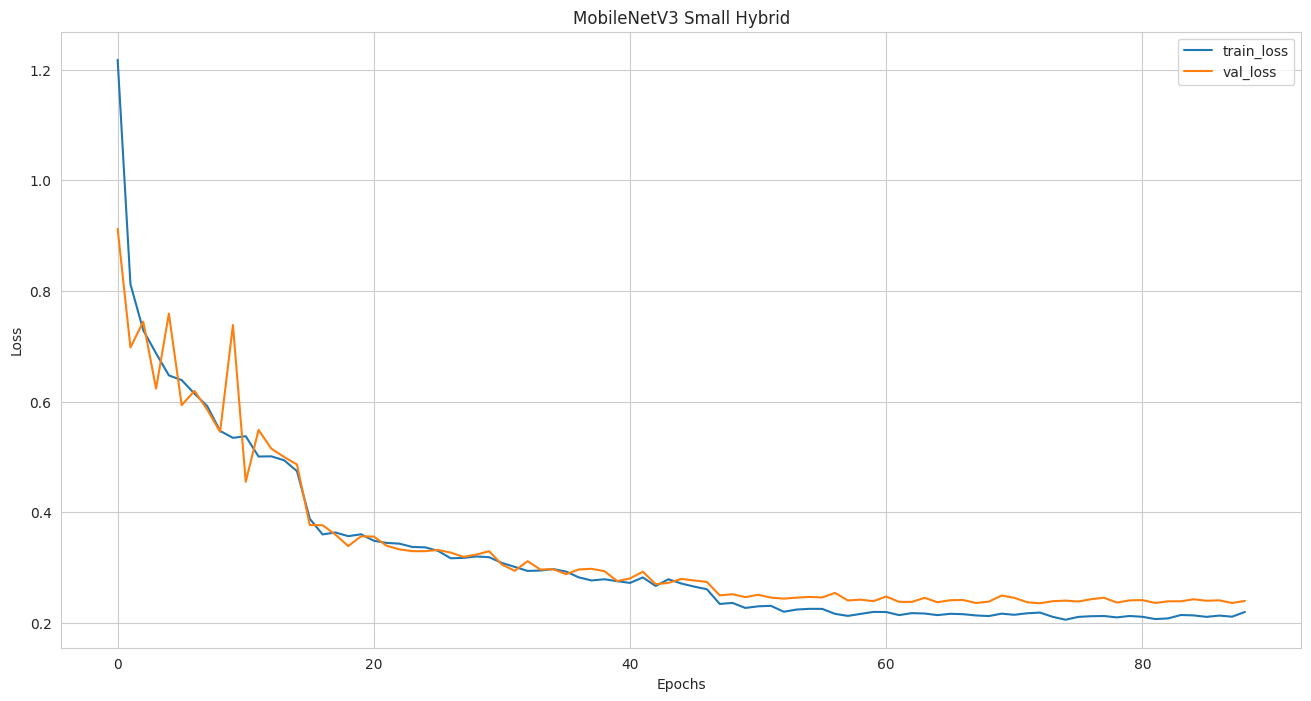

In [31]:
plotLearningCurve(hybrid_history, "MobileNetV3 Small Hybrid")

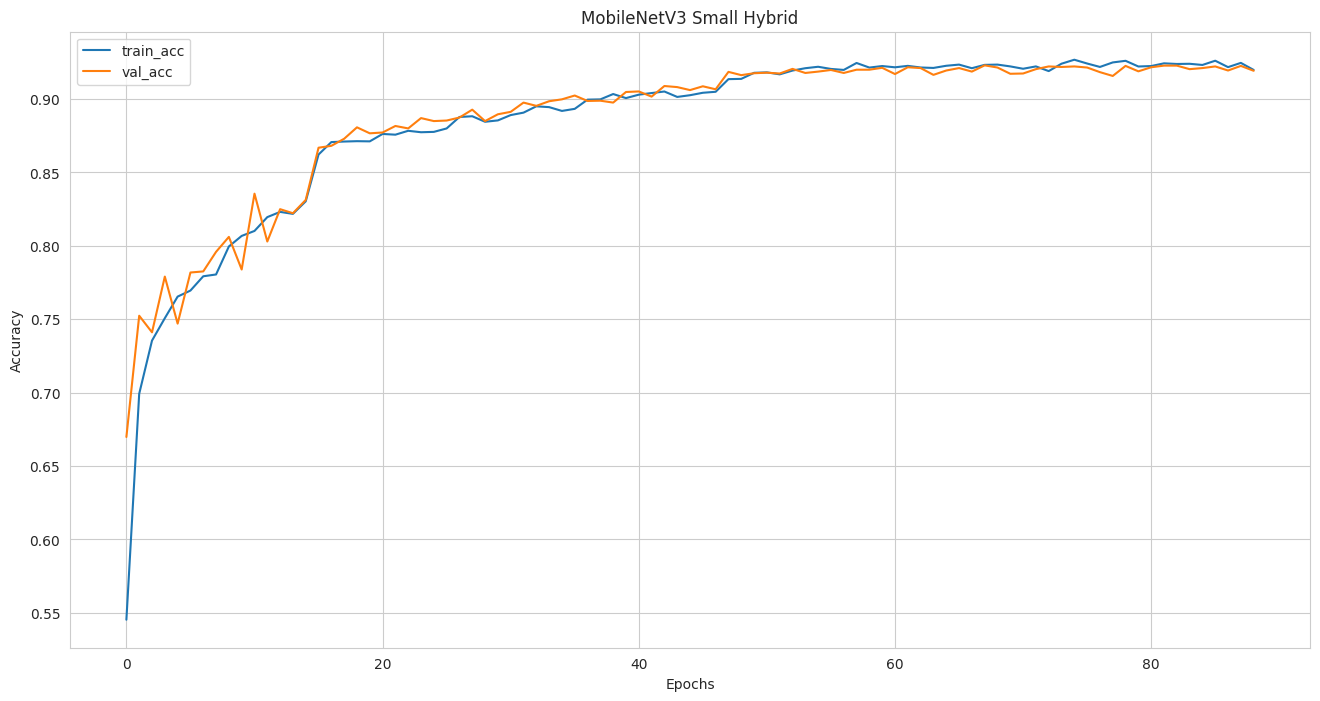

In [32]:
plotAccuracyCurve(hybrid_history, "MobileNetV3 Small Hybrid")

## Confusion Matrix

In [33]:
def plot_confusion_matrix(model, test_loader, title):
    """
    Plot a confusion matrix for model performance evaluation

    Args:
        model (nn.Module): Trained PyTorch model
        test_loader (DataLoader): Test/validation dataloader
        class_names (list): List of class names
    """
    model.eval()
    all_preds, all_labels = infer(model, device, test_loader)
    _, pred = torch.max(all_preds, 1)
    all_preds = pred.tolist()
    all_labels = all_labels.cpu().tolist()

    # Compute confusion matrix
    cm = confusion_matrix(
        [class_mapping[i] for i in all_labels], [class_mapping[i] for i in all_preds]
    )

    # Normalize the confusion matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Plot settings
    plt.figure(figsize=(10, 6))
    plt.title(title)
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_mapping.values(),
        yticklabels=class_mapping.values(),
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

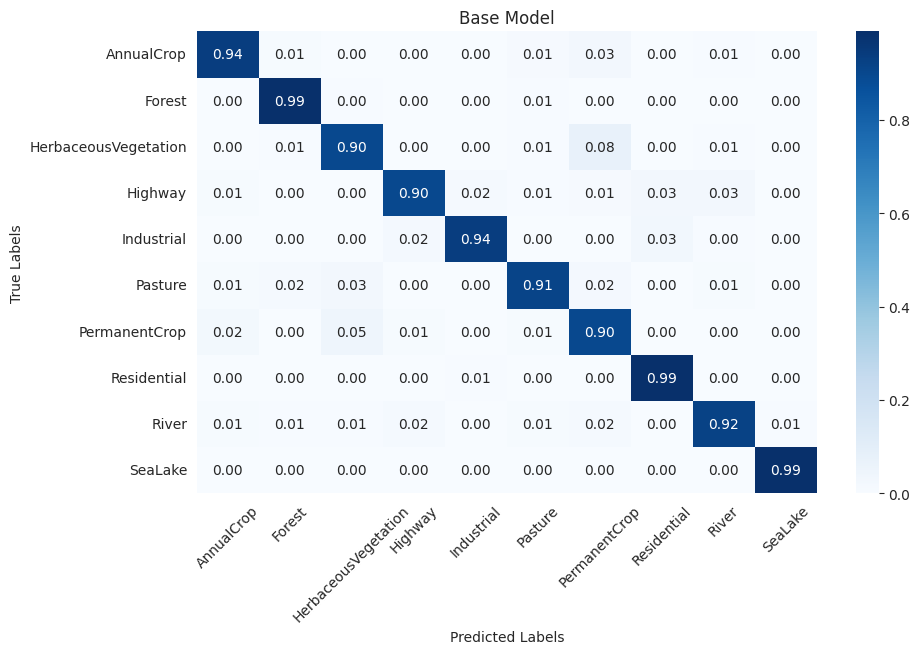

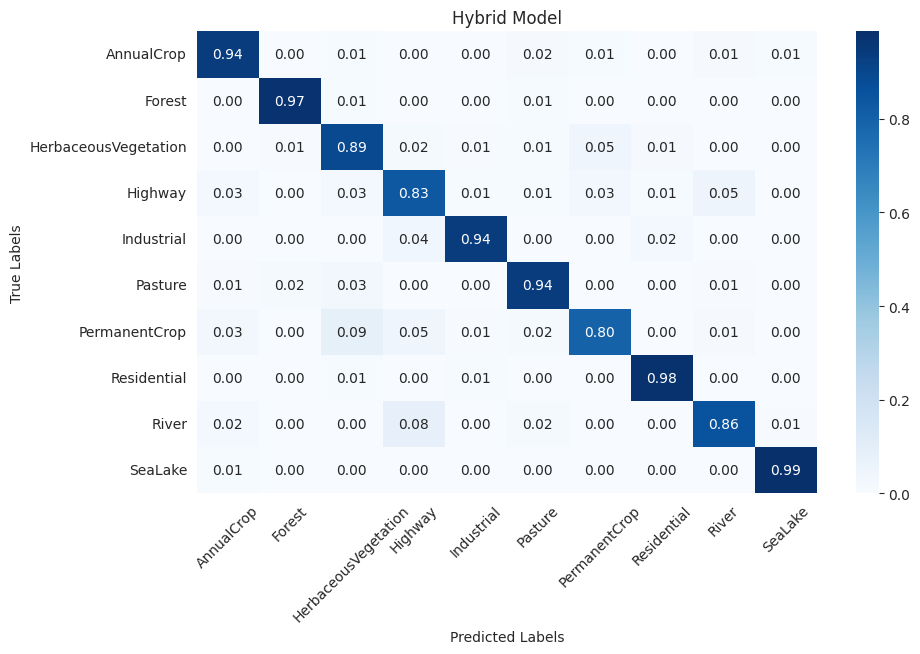

In [34]:
plot_confusion_matrix(base_model, test_loader, "Base Model")
plot_confusion_matrix(hybrid_model, test_loader, "Hybrid Model")

## Model classifcation report 

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve


def F1_score_and_classifcation_report(model, test_loader):
    """
    Model Accuracy report and f1 score

     Args:
         model (nn.Module): Trained PyTorch model
         test_loader (DataLoader): Test/validation dataloader
         class_names (list): List of class names
    """
    model.eval()
    all_preds, all_labels = infer(model, "cuda", test_loader)
    _, pred = torch.max(all_preds, 1)
    pred = pred.cpu().tolist()
    all_labels = all_labels.cpu().tolist()

    # Accuracy
    acc = (np.array(pred) == np.array(all_labels)).mean()
    print(f"Model Accuracy: {acc:.4f}")

    # Print formatted report
    print("Classification Report:")
    print(
        classification_report(
            all_labels, pred, target_names=class_mapping.values()
        )
    )
    print(
        "------------------------------------------------------------------------------"
    )

    # ROC AUC
    y_pred_prob = torch.softmax(all_preds, dim=1)
    y_pred_prob = y_pred_prob.cpu().numpy()
    y_true_onehot = np.eye(len(class_mapping))[all_labels]
    
    roc_auc = {}
    for i in range(len(class_mapping)):
        roc_auc[class_mapping[i]] = roc_auc_score(y_true_onehot[:, i], y_pred_prob[:, i])
        
    for key, value in roc_auc.items():
        print(f"ROC AUC for {key}: {value:.4f}")
    print(
        "------------------------------------------------------------------------------"
    )
    
    plt.figure(figsize=(8, 6))
    plt.title("ROC AUC")
    for i in range(len(class_mapping)):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f"{class_mapping[i]} (AUC = {roc_auc[class_mapping[i]]:.2f})")
        
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
        
    

### classification Report for Base Model

Model Accuracy: 0.9394
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.94      0.94       596
              Forest       0.97      0.99      0.98       608
HerbaceousVegetation       0.91      0.90      0.91       573
             Highway       0.94      0.90      0.92       496
          Industrial       0.97      0.94      0.95       501
             Pasture       0.92      0.91      0.92       396
       PermanentCrop       0.85      0.90      0.87       538
         Residential       0.94      0.99      0.97       554
               River       0.94      0.92      0.93       529
             SeaLake       0.99      0.99      0.99       609

            accuracy                           0.94      5400
           macro avg       0.94      0.94      0.94      5400
        weighted avg       0.94      0.94      0.94      5400

------------------------------------------------------------------------------
ROC 

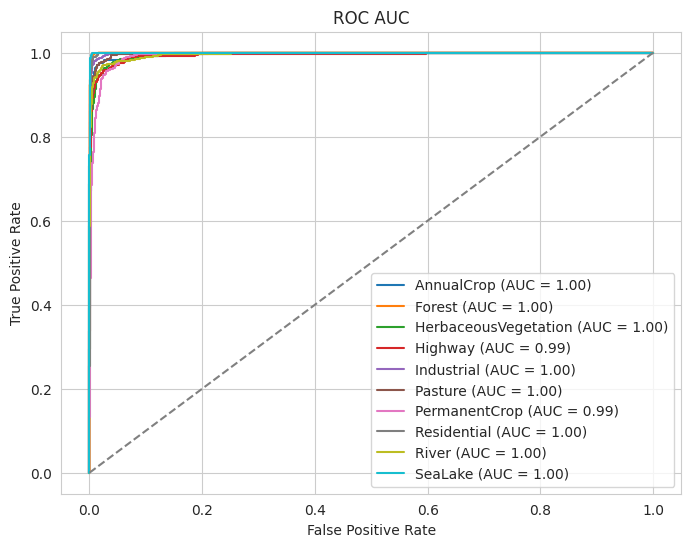

In [36]:
# Assuming you have a trained model and test_loader
F1_score_and_classifcation_report(base_model, test_loader)

### classification Report for Hybrid Model

Model Accuracy: 0.9152
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.94      0.93       596
              Forest       0.98      0.97      0.97       608
HerbaceousVegetation       0.85      0.89      0.87       573
             Highway       0.80      0.83      0.82       496
          Industrial       0.97      0.94      0.95       501
             Pasture       0.89      0.94      0.91       396
       PermanentCrop       0.89      0.80      0.84       538
         Residential       0.96      0.98      0.97       554
               River       0.91      0.86      0.88       529
             SeaLake       0.98      0.99      0.98       609

            accuracy                           0.92      5400
           macro avg       0.91      0.91      0.91      5400
        weighted avg       0.92      0.92      0.91      5400

------------------------------------------------------------------------------
ROC 

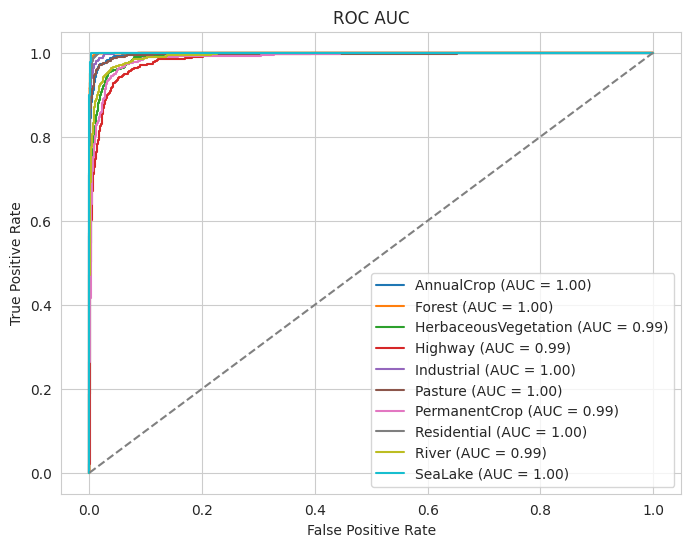

In [37]:
# Assuming you have a trained model and test_loader
F1_score_and_classifcation_report(hybrid_model, test_loader)

# Changing activation function in BottleNeck

The paper claimed hardswish helped reducing training time and increase accuracy comparing to ReLU. So I will try some new relatives of ReLU, which solved dying neurons problems.For simplicity we are using the base model since its faster to train and tune.

## Base model

Record referencing time of base model

In [47]:
%%time
pred, actual = infer(base_model, device, test_loader)
valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()
print(f'The accuracy on unseen data is :{np.round(valAcc.item(),2)*100} %')

The accuracy on unseen data is :94.0 %
CPU times: user 838 ms, sys: 8 ms, total: 846 ms
Wall time: 845 ms


## GELU

In [39]:
model = MobileNetV3(in_chn=3, mode="small", num_classes=10, deep_activation=GELU)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [40]:
%%time
history = train(
    model=model.to(device),
    device=device,
    trainLoader=train_loader,
    valLoader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    earlyStopping=earlyStopping,
)

Epoch [1/100], Step [0/254], Loss: 2.3101, Accuracy: 0.0781
Epoch [1/100], Step [100/254], Loss: 1.1349, Accuracy: 0.5781
Epoch [1/100], Step [200/254], Loss: 0.8992, Accuracy: 0.6250
Epoch [1/100], Train Loss: 1.1834, Val Loss: 0.9562, Train Acc: 0.5672, Val Acc: 0.6580
Time: 0.0 min 8.49 sec
Epoch [2/100], Step [0/254], Loss: 0.9149, Accuracy: 0.6406
Epoch [2/100], Step [100/254], Loss: 0.8786, Accuracy: 0.7031
Epoch [2/100], Step [200/254], Loss: 0.7265, Accuracy: 0.7344
Epoch [2/100], Train Loss: 0.8545, Val Loss: 0.7280, Train Acc: 0.7000, Val Acc: 0.7306
Time: 0.0 min 8.64 sec
Epoch [3/100], Step [0/254], Loss: 0.6694, Accuracy: 0.7812
Epoch [3/100], Step [100/254], Loss: 0.9675, Accuracy: 0.6406
Epoch [3/100], Step [200/254], Loss: 0.7188, Accuracy: 0.7812
Epoch [3/100], Train Loss: 0.7386, Val Loss: 0.7897, Train Acc: 0.7357, Val Acc: 0.7280
Time: 0.0 min 8.61 sec
Epoch [4/100], Step [0/254], Loss: 0.5806, Accuracy: 0.7969
Epoch [4/100], Step [100/254], Loss: 0.6147, Accuracy: 

In [46]:
%%time
pred, actual = infer(model, device, test_loader)
valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()
print(f'The accuracy on unseen data is :{np.round(valAcc.item(),2)*100} %')

The accuracy on unseen data is :95.0 %
CPU times: user 833 ms, sys: 8 ms, total: 841 ms
Wall time: 840 ms


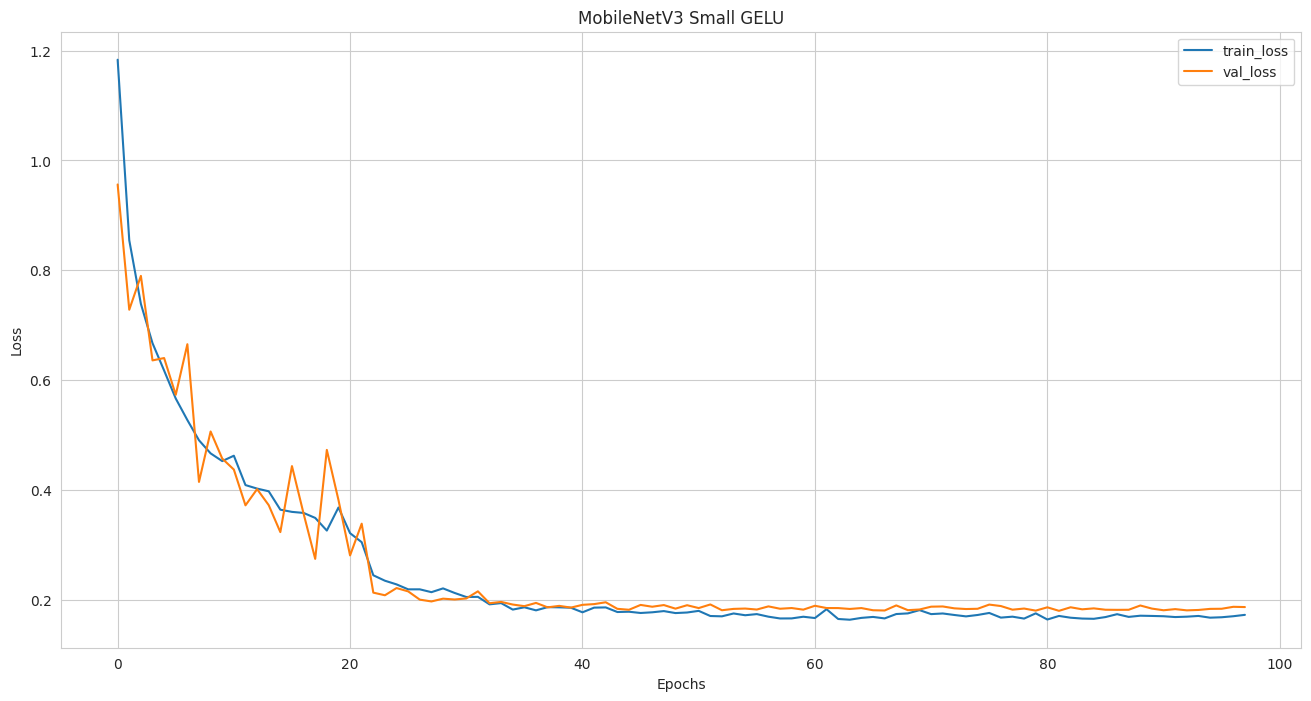

In [48]:
plotLearningCurve(history, "MobileNetV3 Small GELU")

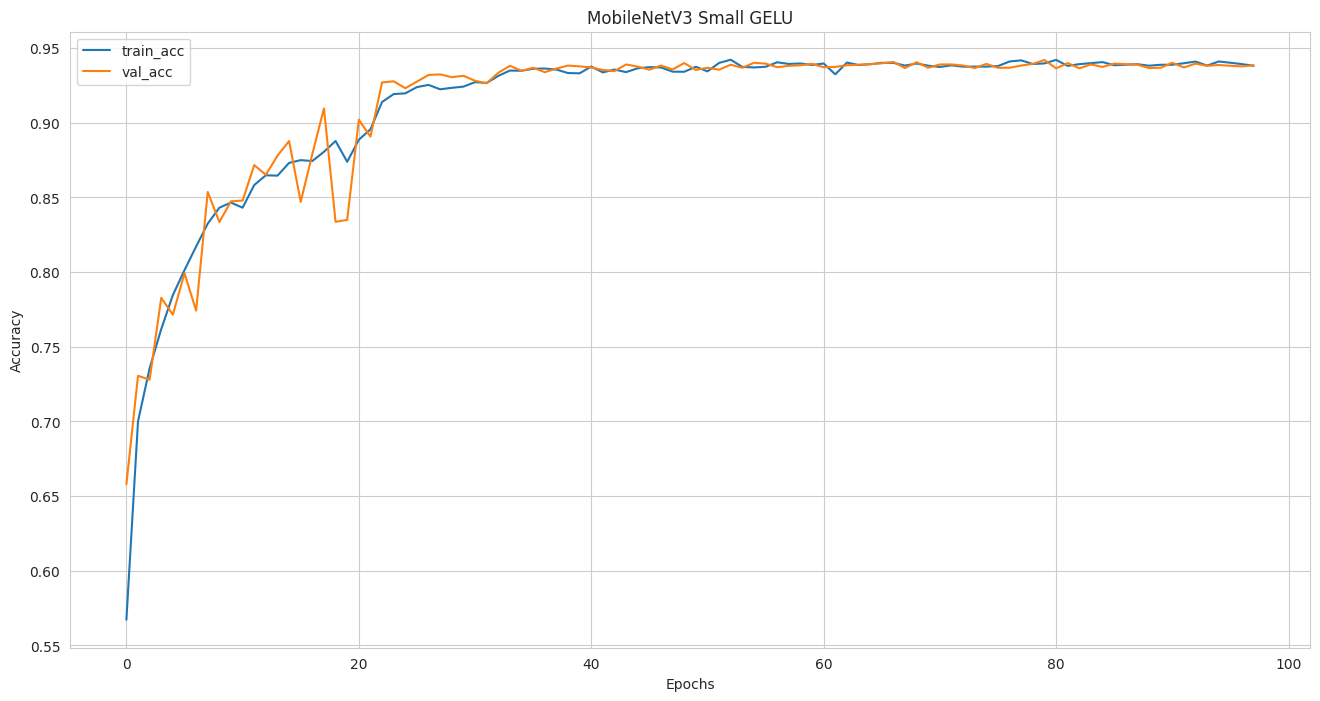

In [49]:
plotAccuracyCurve(history, "MobileNetV3 Small GELU")

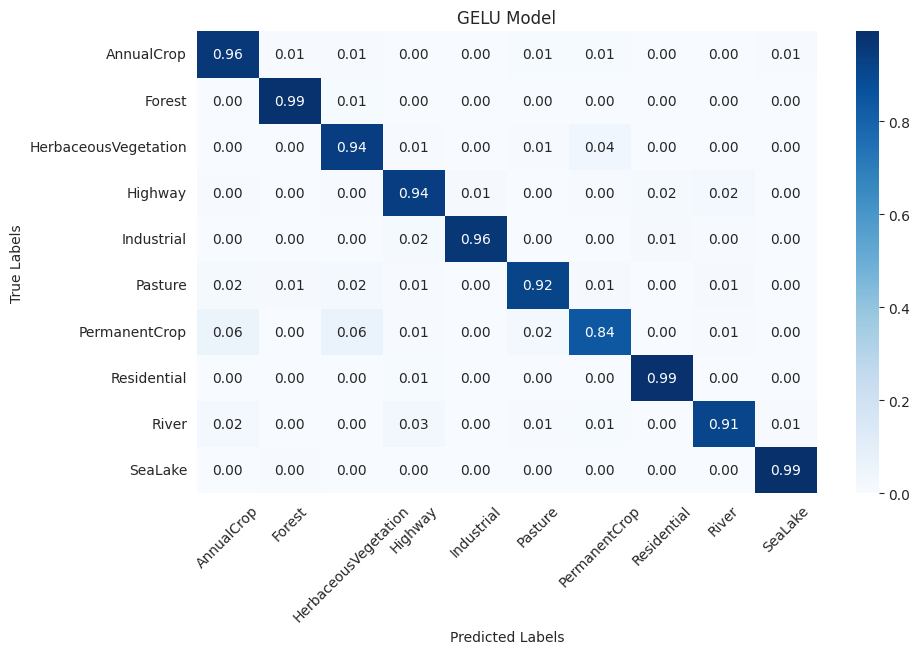

In [50]:
plot_confusion_matrix(model, test_loader, "GELU Model")

Model Accuracy: 0.9456
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.96      0.93       596
              Forest       0.98      0.99      0.98       608
HerbaceousVegetation       0.91      0.94      0.92       573
             Highway       0.92      0.94      0.93       496
          Industrial       0.98      0.96      0.97       501
             Pasture       0.94      0.92      0.93       396
       PermanentCrop       0.92      0.84      0.88       538
         Residential       0.97      0.99      0.98       554
               River       0.95      0.91      0.93       529
             SeaLake       0.99      0.99      0.99       609

            accuracy                           0.95      5400
           macro avg       0.94      0.94      0.94      5400
        weighted avg       0.95      0.95      0.95      5400

------------------------------------------------------------------------------
ROC 

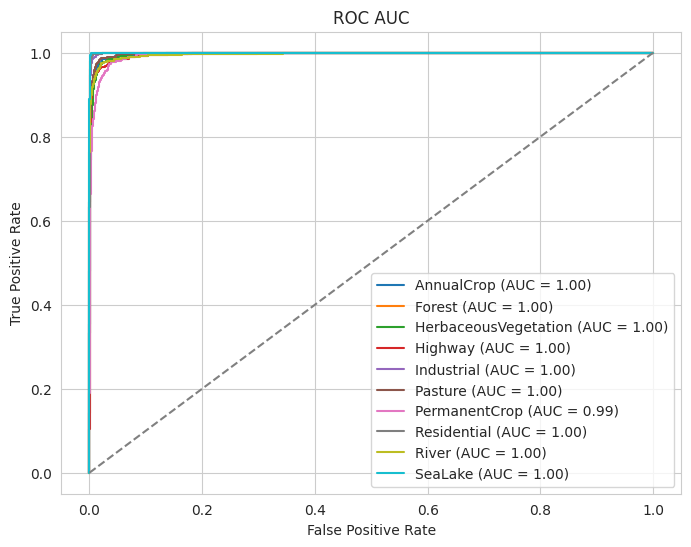

In [51]:
F1_score_and_classifcation_report(model, test_loader)

## Leaky ReLU 

In [52]:
model = MobileNetV3(in_chn=3, mode="small", num_classes=10, deep_activation=nn.LeakyReLU)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [53]:
%%time
history = train(
    model=model.to(device),
    device=device,
    trainLoader=train_loader,
    valLoader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    earlyStopping=earlyStopping,
)

Epoch [1/100], Step [0/254], Loss: 2.3043, Accuracy: 0.0625
Epoch [1/100], Step [100/254], Loss: 1.1393, Accuracy: 0.5156
Epoch [1/100], Step [200/254], Loss: 1.0281, Accuracy: 0.5938
Epoch [1/100], Train Loss: 1.2030, Val Loss: 1.4078, Train Acc: 0.5690, Val Acc: 0.5433
Time: 0.0 min 7.53 sec
Epoch [2/100], Step [0/254], Loss: 1.0985, Accuracy: 0.5000
Epoch [2/100], Step [100/254], Loss: 0.8384, Accuracy: 0.6562
Epoch [2/100], Step [200/254], Loss: 0.6144, Accuracy: 0.7344
Epoch [2/100], Train Loss: 0.8586, Val Loss: 0.7873, Train Acc: 0.6977, Val Acc: 0.7180
Time: 0.0 min 7.49 sec
Epoch [3/100], Step [0/254], Loss: 0.6704, Accuracy: 0.7500
Epoch [3/100], Step [100/254], Loss: 0.8409, Accuracy: 0.7656
Epoch [3/100], Step [200/254], Loss: 0.8595, Accuracy: 0.6719
Epoch [3/100], Train Loss: 0.7667, Val Loss: 0.6945, Train Acc: 0.7251, Val Acc: 0.7539
Time: 0.0 min 7.50 sec
Epoch [4/100], Step [0/254], Loss: 0.9236, Accuracy: 0.7344
Epoch [4/100], Step [100/254], Loss: 0.6637, Accuracy: 

In [59]:
%%time
pred, actual = infer(model, device, test_loader)
valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()
print(f'The accuracy on unseen data is :{np.round(valAcc.item(),2)*100} %')

The accuracy on unseen data is :92.0 %
CPU times: user 835 ms, sys: 4 ms, total: 839 ms
Wall time: 838 ms


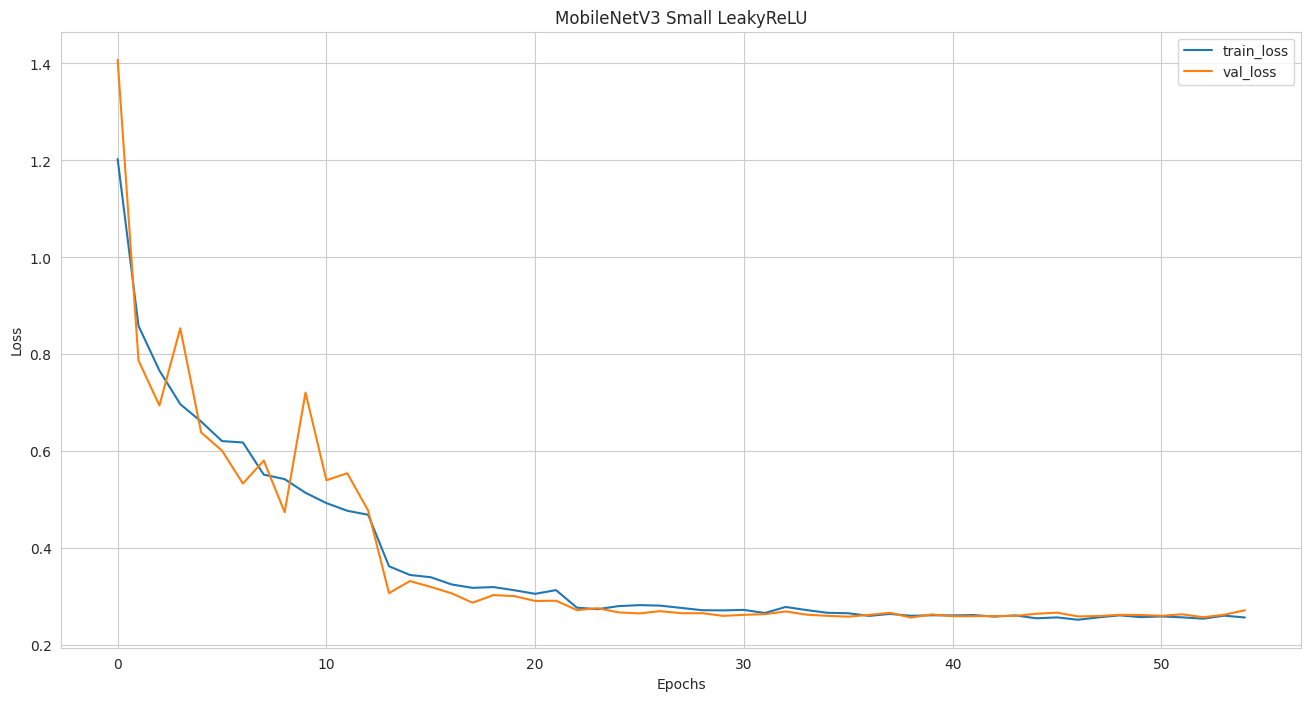

In [60]:
plotLearningCurve(history, "MobileNetV3 Small LeakyReLU")

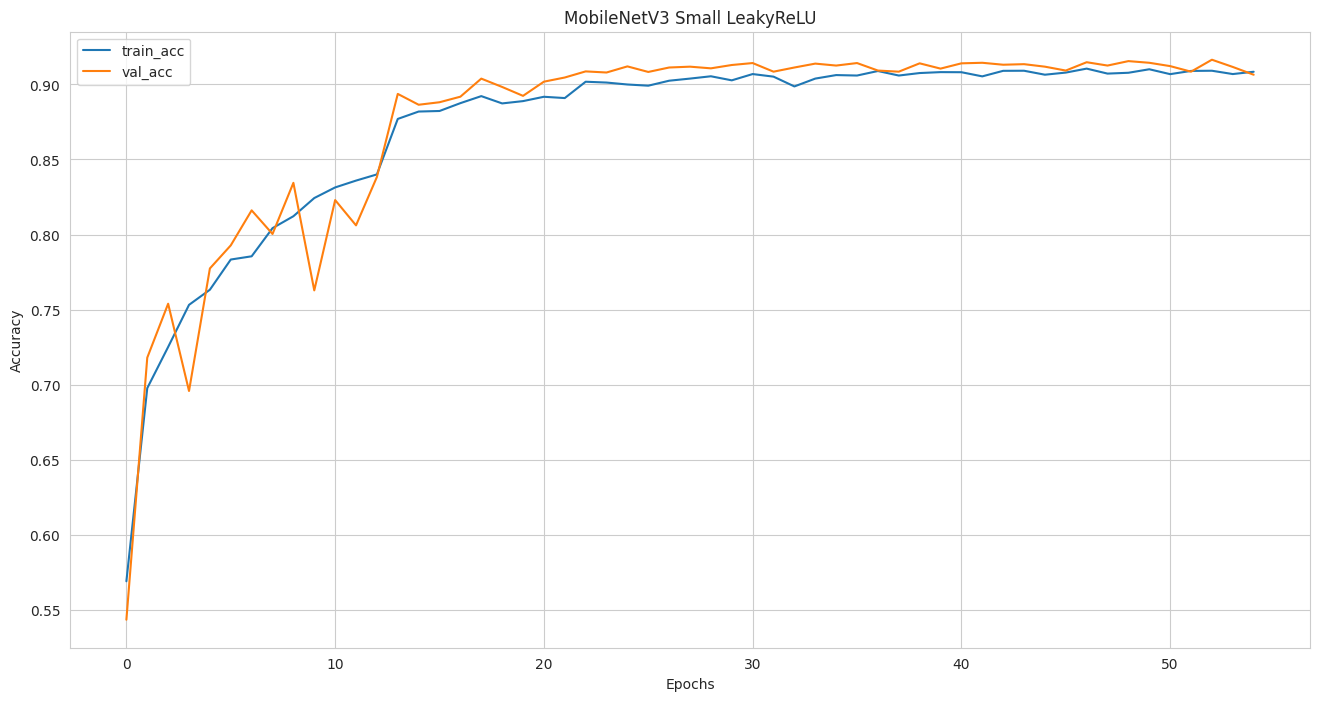

In [61]:
plotAccuracyCurve(history, "MobileNetV3 Small LeakyReLU")

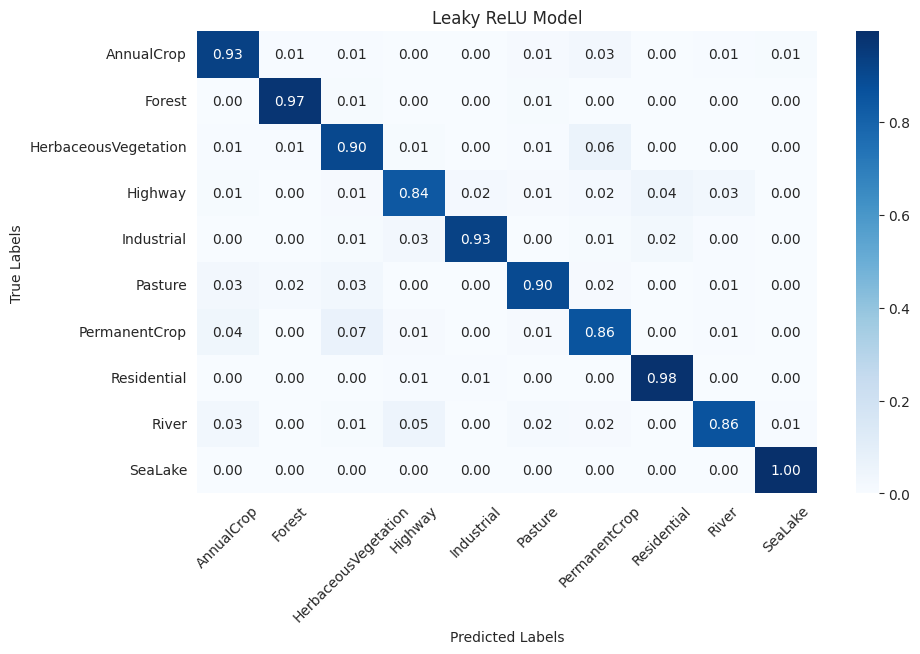

In [62]:
plot_confusion_matrix(model, test_loader, "Leaky ReLU Model")

Model Accuracy: 0.9196
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.90      0.93      0.92       596
              Forest       0.97      0.97      0.97       608
HerbaceousVegetation       0.87      0.90      0.89       573
             Highway       0.88      0.84      0.86       496
          Industrial       0.96      0.93      0.94       501
             Pasture       0.89      0.90      0.90       396
       PermanentCrop       0.85      0.86      0.85       538
         Residential       0.94      0.98      0.96       554
               River       0.93      0.86      0.90       529
             SeaLake       0.98      1.00      0.99       609

            accuracy                           0.92      5400
           macro avg       0.92      0.92      0.92      5400
        weighted avg       0.92      0.92      0.92      5400

------------------------------------------------------------------------------
ROC 

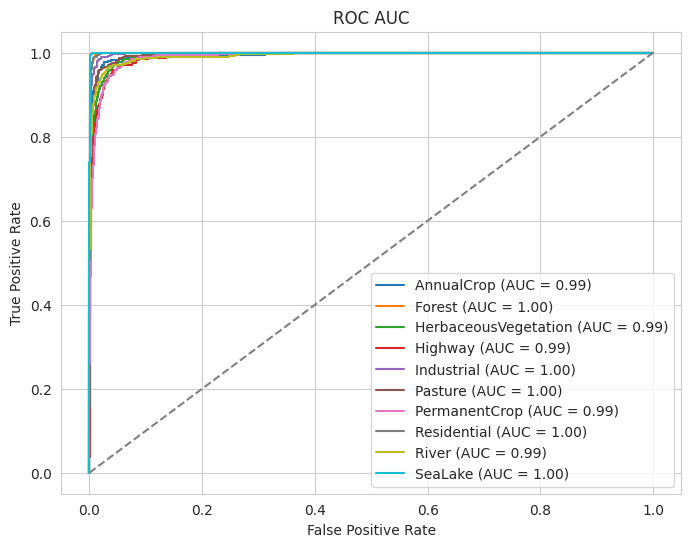

In [63]:
F1_score_and_classifcation_report(model, test_loader)

## ELU

In [64]:
model = MobileNetV3(in_chn=3, mode="small", num_classes=10, deep_activation=nn.ELU)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [65]:
%%time
history = train(
    model=model.to(device),
    device=device,
    trainLoader=train_loader,
    valLoader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    earlyStopping=earlyStopping,
)

Epoch [1/100], Step [0/254], Loss: 2.3139, Accuracy: 0.1094
Epoch [1/100], Step [100/254], Loss: 1.0669, Accuracy: 0.6562
Epoch [1/100], Step [200/254], Loss: 1.0318, Accuracy: 0.6406
Epoch [1/100], Train Loss: 1.1055, Val Loss: 0.9033, Train Acc: 0.5973, Val Acc: 0.6750
Time: 0.0 min 7.57 sec
Epoch [2/100], Step [0/254], Loss: 0.9363, Accuracy: 0.7188
Epoch [2/100], Step [100/254], Loss: 0.7063, Accuracy: 0.7344
Epoch [2/100], Step [200/254], Loss: 0.7468, Accuracy: 0.7344
Epoch [2/100], Train Loss: 0.8080, Val Loss: 1.0868, Train Acc: 0.7116, Val Acc: 0.6420
Time: 0.0 min 7.51 sec
Epoch [3/100], Step [0/254], Loss: 0.7418, Accuracy: 0.7031
Epoch [3/100], Step [100/254], Loss: 0.7811, Accuracy: 0.7500
Epoch [3/100], Step [200/254], Loss: 0.9608, Accuracy: 0.7031
Epoch [3/100], Train Loss: 0.7309, Val Loss: 0.6526, Train Acc: 0.7391, Val Acc: 0.7631
Time: 0.0 min 7.52 sec
Epoch [4/100], Step [0/254], Loss: 0.7435, Accuracy: 0.7031
Epoch [4/100], Step [100/254], Loss: 0.7831, Accuracy: 

In [71]:
%%time
pred, actual = infer(model, device, test_loader)
valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()
print(f'The accuracy on unseen data is :{np.round(valAcc.item(),2)*100} %')

The accuracy on unseen data is :94.0 %
CPU times: user 825 ms, sys: 8 ms, total: 833 ms
Wall time: 832 ms


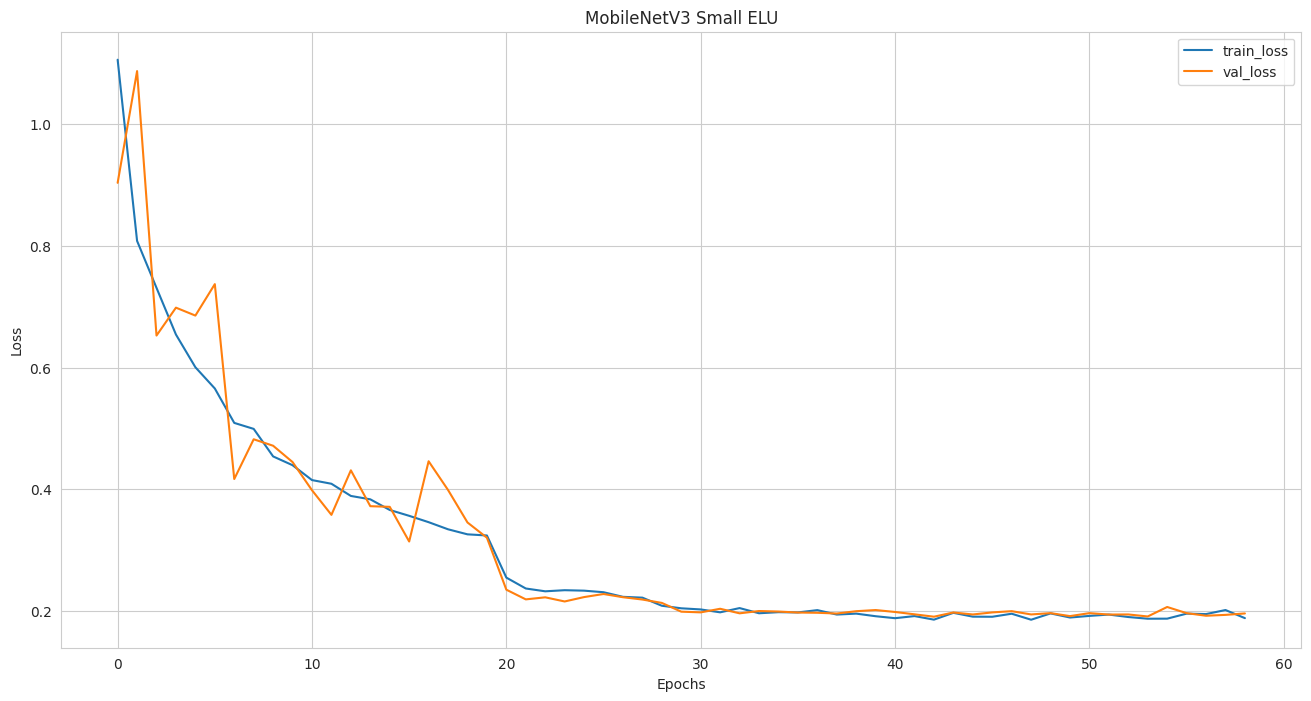

In [67]:
plotLearningCurve(history, "MobileNetV3 Small ELU")

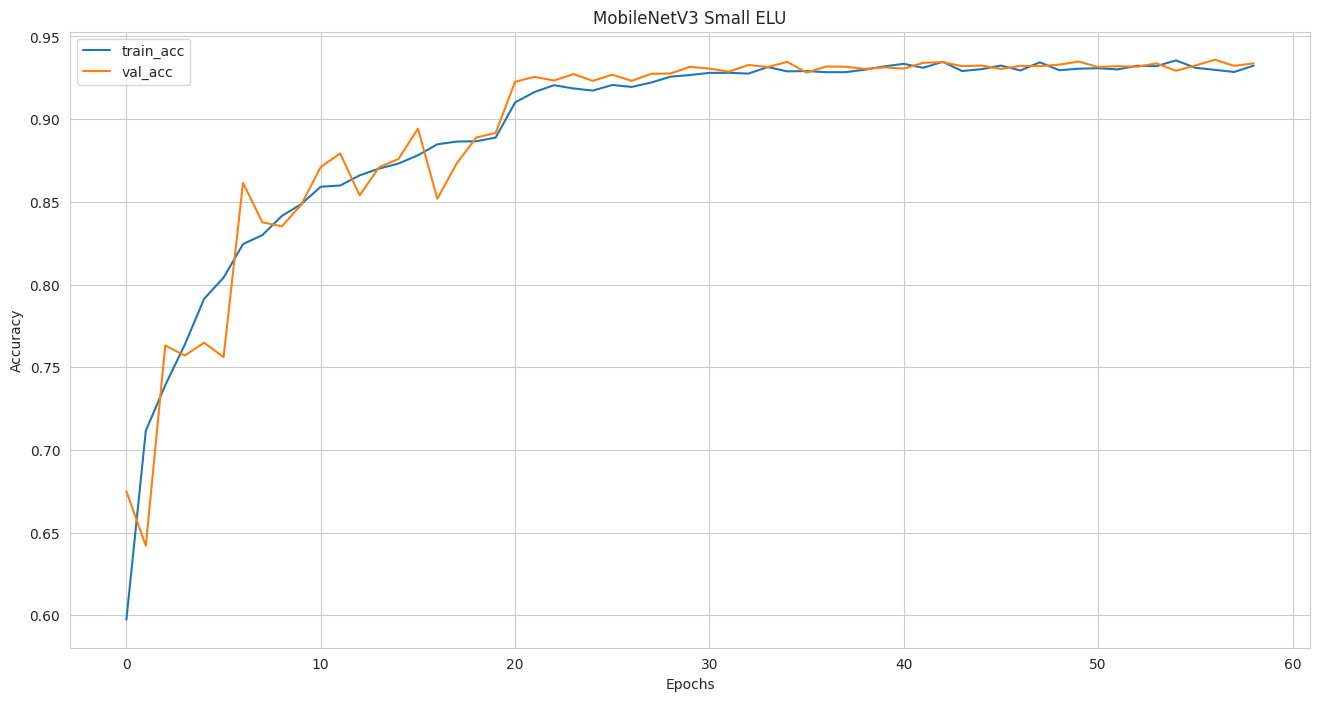

In [72]:
plotAccuracyCurve(history, "MobileNetV3 Small ELU")

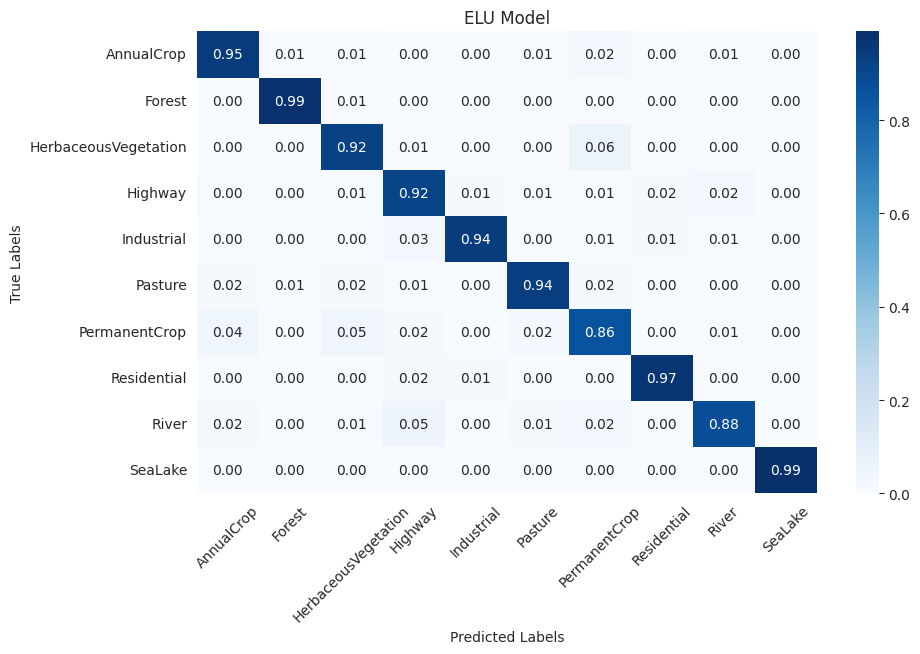

In [73]:
plot_confusion_matrix(model, test_loader, "ELU Model")

Model Accuracy: 0.9369
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.95      0.94       596
              Forest       0.99      0.99      0.99       608
HerbaceousVegetation       0.91      0.92      0.92       573
             Highway       0.87      0.92      0.89       496
          Industrial       0.97      0.94      0.95       501
             Pasture       0.91      0.94      0.92       396
       PermanentCrop       0.87      0.86      0.86       538
         Residential       0.97      0.97      0.97       554
               River       0.94      0.88      0.91       529
             SeaLake       0.99      0.99      0.99       609

            accuracy                           0.94      5400
           macro avg       0.94      0.94      0.93      5400
        weighted avg       0.94      0.94      0.94      5400

------------------------------------------------------------------------------
ROC 

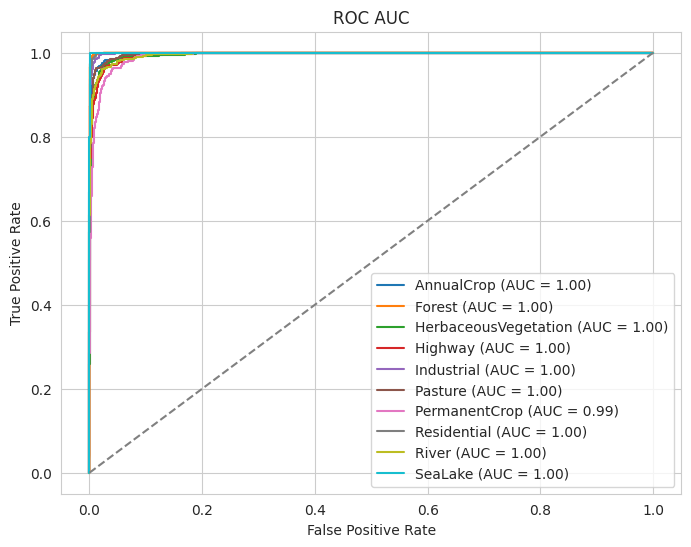

In [74]:
F1_score_and_classifcation_report(model, test_loader)

## Hard-ELU

In [75]:
def hardElu(x, alpha=1.0, inplace=False):
    safe_x = torch.where(x < 0.0, x, torch.zeros_like(x))

    if inplace:
        x[:] = torch.where(x < 0.0, alpha * safe_x / (1 - safe_x), x)
        return x
    else:
        return torch.where(x < 0.0, alpha * safe_x / (1 - safe_x), x)


class HardELU(nn.Module):
    def __init__(self, alpha=1.0, inplace=False):
        super().__init__()
        self.alpha = alpha
        self.inplace = inplace

    def forward(self, x):
        return hardElu(x, self.alpha, self.inplace)

In [76]:
model = MobileNetV3(in_chn=3, mode="small", num_classes=10, deep_activation=HardELU)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [77]:
%%time
history = train(
    model=model.to(device),
    device=device,
    trainLoader=train_loader,
    valLoader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    earlyStopping=earlyStopping,
)

Epoch [1/100], Step [0/254], Loss: 2.3050, Accuracy: 0.0781
Epoch [1/100], Step [100/254], Loss: 1.1667, Accuracy: 0.5938
Epoch [1/100], Step [200/254], Loss: 0.8134, Accuracy: 0.6094
Epoch [1/100], Train Loss: 1.1806, Val Loss: 0.8576, Train Acc: 0.5671, Val Acc: 0.7061
Time: 0.0 min 9.70 sec
Epoch [2/100], Step [0/254], Loss: 0.8971, Accuracy: 0.7031
Epoch [2/100], Step [100/254], Loss: 0.8991, Accuracy: 0.6875
Epoch [2/100], Step [200/254], Loss: 0.7612, Accuracy: 0.7656
Epoch [2/100], Train Loss: 0.8324, Val Loss: 0.8822, Train Acc: 0.7036, Val Acc: 0.6785
Time: 0.0 min 9.46 sec
Epoch [3/100], Step [0/254], Loss: 0.7347, Accuracy: 0.7188
Epoch [3/100], Step [100/254], Loss: 1.0088, Accuracy: 0.5625
Epoch [3/100], Step [200/254], Loss: 0.7258, Accuracy: 0.7031
Epoch [3/100], Train Loss: 0.7566, Val Loss: 0.7740, Train Acc: 0.7293, Val Acc: 0.7098
Time: 0.0 min 9.57 sec
Epoch [4/100], Step [0/254], Loss: 0.6548, Accuracy: 0.7188
Epoch [4/100], Step [100/254], Loss: 0.6107, Accuracy: 

In [78]:
%%time
pred, actual = infer(model, device, test_loader)
valAcc = (torch.argmax(pred, dim=1) == actual).float().mean()
print(f'The accuracy on unseen data is :{np.round(valAcc.item(),2)*100} %')

The accuracy on unseen data is :93.0 %
CPU times: user 920 ms, sys: 4 ms, total: 924 ms
Wall time: 923 ms


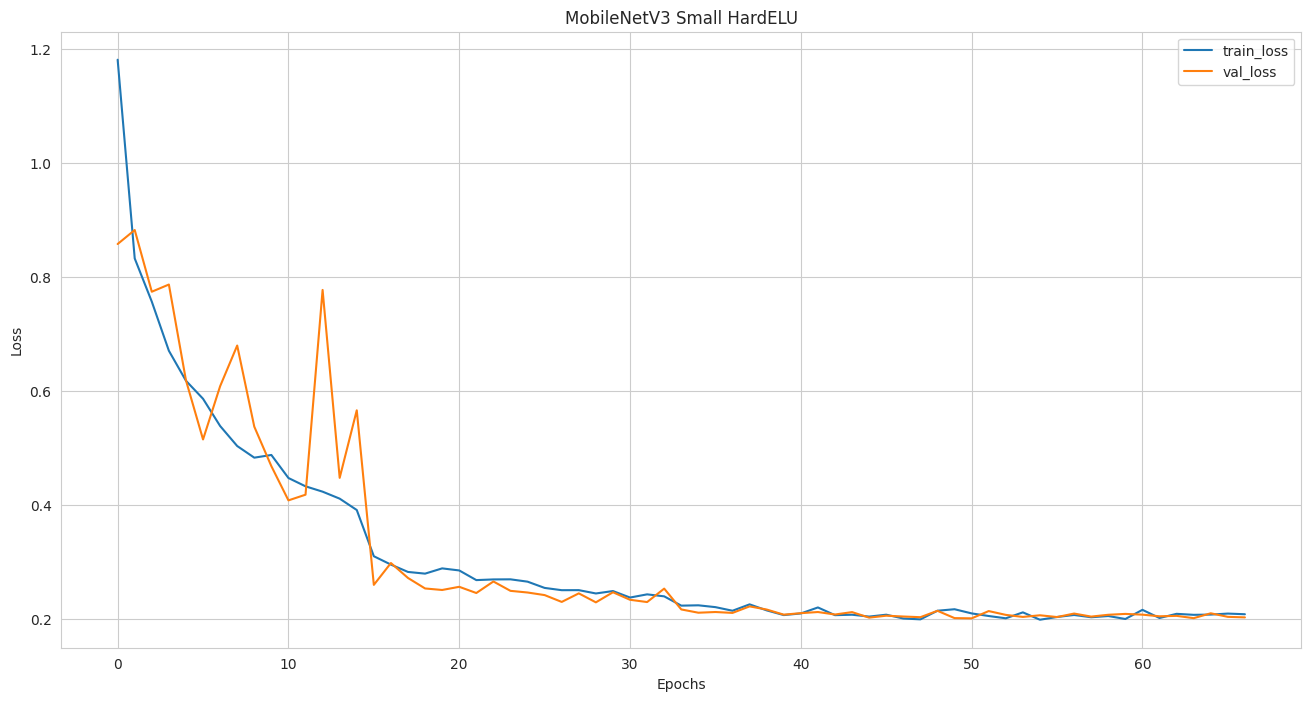

In [79]:
plotLearningCurve(history, "MobileNetV3 Small HardELU")

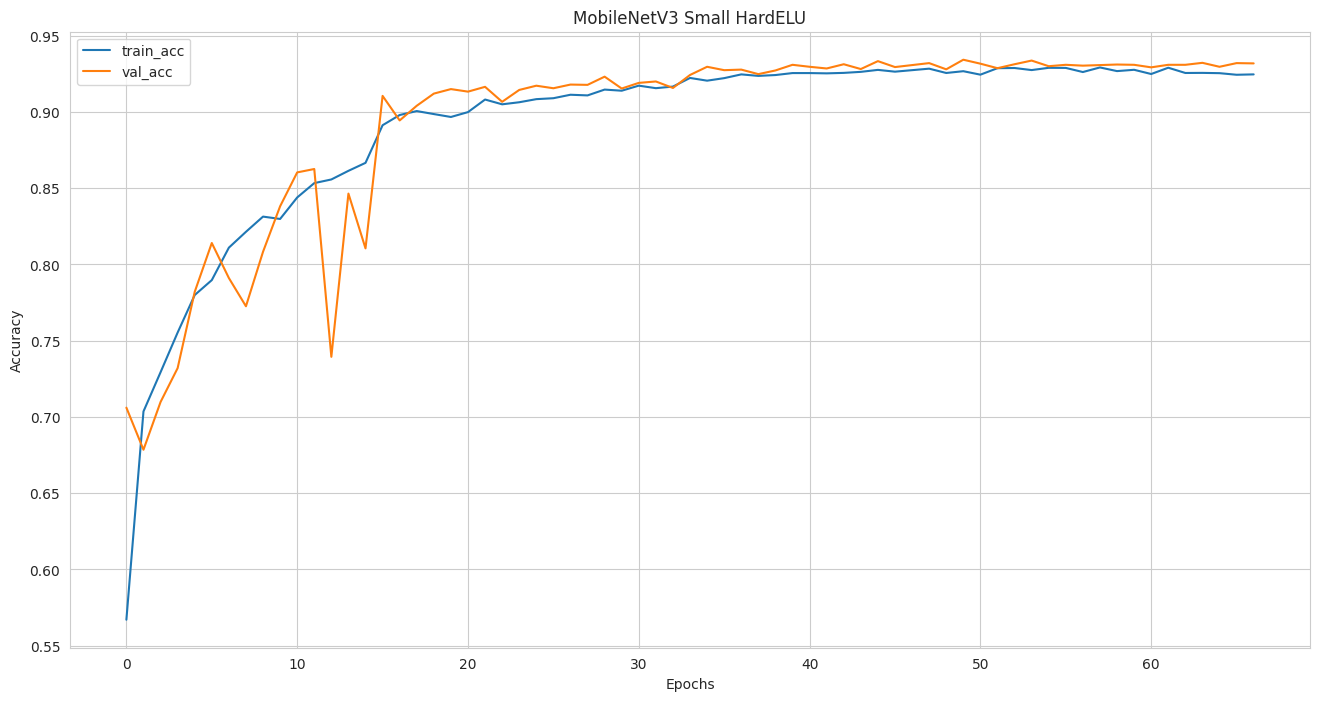

In [80]:
plotAccuracyCurve(history, "MobileNetV3 Small HardELU")

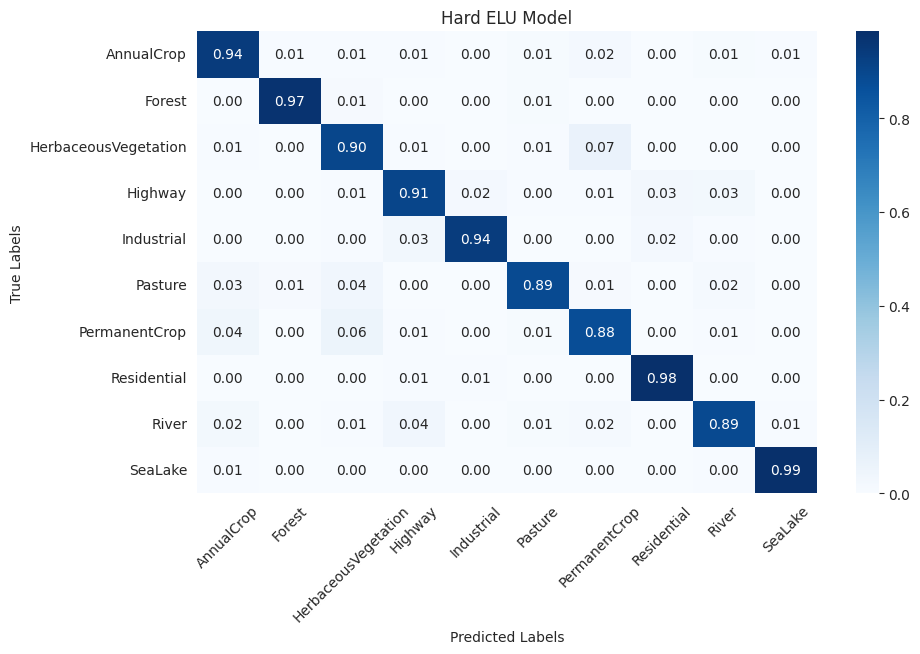

In [81]:
plot_confusion_matrix(model, test_loader, "Hard ELU Model")

Model Accuracy: 0.9315
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.94      0.92       596
              Forest       0.98      0.97      0.98       608
HerbaceousVegetation       0.89      0.90      0.90       573
             Highway       0.90      0.91      0.90       496
          Industrial       0.96      0.94      0.95       501
             Pasture       0.93      0.89      0.91       396
       PermanentCrop       0.87      0.88      0.87       538
         Residential       0.95      0.98      0.97       554
               River       0.93      0.89      0.91       529
             SeaLake       0.99      0.99      0.99       609

            accuracy                           0.93      5400
           macro avg       0.93      0.93      0.93      5400
        weighted avg       0.93      0.93      0.93      5400

------------------------------------------------------------------------------
ROC 

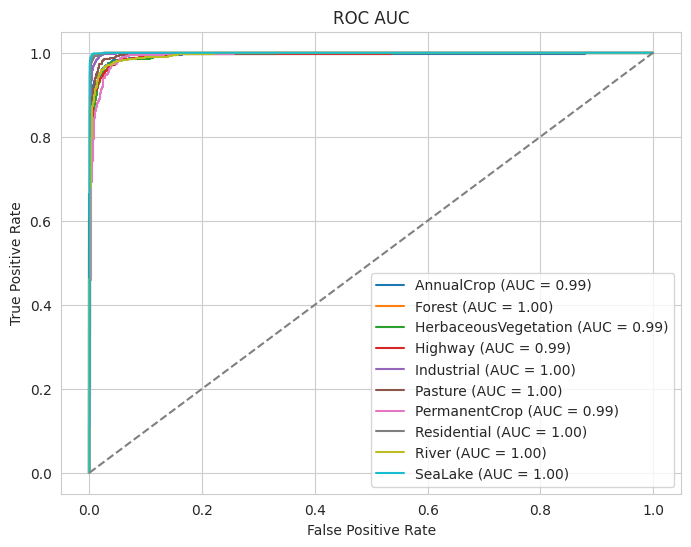

In [83]:
F1_score_and_classifcation_report(model, test_loader)

# Hyper parameter Tuning

This function defines a hyperparameter search for training a MobileNetV3 model. Optuna suggests hyperparameters, initializes the model with those parameters, trains it, and returns a performance metric (average of the last 5 validation accuracies).

In [88]:
def objective(trial):
    # Suggest hyperparameters using Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)  # Log-uniform sampling
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2)
    momentum = (
        trial.suggest_float("momentum", 0.8, 0.99) if optimizer_name == "SGD" else 0.0
    )
    deep_activation = trial.suggest_categorical(
        "deep_activation", [Hardsigmoid, GELU, ELU]
    )

    # Initialize model
    # for simplicity we are using base the model but we can use hybrid version also
    model = MobileNetV3(
        in_chn=3,
        mode="small",
        num_classes=10,
        deep_activation=deep_activation,
        hybrid=False,
    ).to(device)

    # Define optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(
            model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay
        )

    # Train the model
    history = train(
        model=model,
        device=device,
        trainLoader=train_loader,
        valLoader=validation_loader,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        n_epochs=50,
        earlyStopping=15,
    )

    # Return the best validation accuracy (what Optuna will maximize)
    return sum(history["val_acc"][-5:]) / 5

In [ ]:
study = optuna.create_study(
    direction="maximize",  # Maximize validation accuracy
    sampler=optuna.samplers.TPESampler(),  # Tree-structured Parzen Estimator (Bayesian)
    pruner=optuna.pruners.MedianPruner(),  # Prune unpromising trials early
)

# Run optimization (adjust n_trials as needed)
study.optimize(objective, n_trials=10)  # change this paramater  note note

# Print the best result
print("Best trial:")
trial = study.best_trial
print(f"Validation Accuracy: {trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

[I 2025-03-19 14:07:50,526] A new study created in memory with name: no-name-c404b26a-5f75-4b8f-8c61-26853521fd24


Epoch [1/50], Step [0/254], Loss: 2.3110, Accuracy: 0.1250
Epoch [1/50], Step [100/254], Loss: 2.2775, Accuracy: 0.2188
Epoch [1/50], Step [200/254], Loss: 2.1304, Accuracy: 0.1250
Epoch [1/50], Train Loss: 2.1876, Val Loss: 1.9440, Train Acc: 0.2204, Val Acc: 0.2400
Time: 0.0 min 7.51 sec
Epoch [2/50], Step [0/254], Loss: 2.0092, Accuracy: 0.2188
Epoch [2/50], Step [100/254], Loss: 1.6814, Accuracy: 0.3594
Epoch [2/50], Step [200/254], Loss: 1.5449, Accuracy: 0.3906
Epoch [2/50], Train Loss: 1.7221, Val Loss: 1.5660, Train Acc: 0.3230, Val Acc: 0.3857
Time: 0.0 min 7.49 sec
Epoch [3/50], Step [0/254], Loss: 1.3957, Accuracy: 0.4844
Epoch [3/50], Step [100/254], Loss: 1.3385, Accuracy: 0.4375
Epoch [3/50], Step [200/254], Loss: 1.4218, Accuracy: 0.4688
Epoch [3/50], Train Loss: 1.4294, Val Loss: 1.2933, Train Acc: 0.4536, Val Acc: 0.5067
Time: 0.0 min 7.48 sec
Epoch [4/50], Step [0/254], Loss: 1.5465, Accuracy: 0.4531
Epoch [4/50], Step [100/254], Loss: 1.2174, Accuracy: 0.5625
Epoch [

[I 2025-03-19 14:14:12,390] Trial 0 finished with value: 0.8836666584014893 and parameters: {'lr': 0.0004598178975099876, 'optimizer': 'SGD', 'weight_decay': 0.001638624502883736, 'momentum': 0.9424541970582119, 'deep_activation': <class 'torch.nn.modules.activation.Hardsigmoid'>}. Best is trial 0 with value: 0.8836666584014893.


Epoch [50/50], Train Loss: 0.3797, Val Loss: 0.3281, Train Acc: 0.8699, Val Acc: 0.8869
Time: 0.0 min 8.33 sec
Epoch [1/50], Step [0/254], Loss: 2.3001, Accuracy: 0.1250
Epoch [1/50], Step [100/254], Loss: 1.4949, Accuracy: 0.4375
Epoch [1/50], Step [200/254], Loss: 1.2505, Accuracy: 0.5000
Epoch [1/50], Train Loss: 1.5634, Val Loss: 1.1912, Train Acc: 0.4526, Val Acc: 0.5648
Time: 0.0 min 8.26 sec
Epoch [2/50], Step [0/254], Loss: 1.1891, Accuracy: 0.6719
Epoch [2/50], Step [100/254], Loss: 1.0409, Accuracy: 0.5312
Epoch [2/50], Step [200/254], Loss: 1.1021, Accuracy: 0.5938
Epoch [2/50], Train Loss: 1.1164, Val Loss: 0.9660, Train Acc: 0.5934, Val Acc: 0.6548
Time: 0.0 min 8.33 sec
Epoch [3/50], Step [0/254], Loss: 1.0849, Accuracy: 0.6250
Epoch [3/50], Step [100/254], Loss: 0.8836, Accuracy: 0.6562
Epoch [3/50], Step [200/254], Loss: 0.8411, Accuracy: 0.7500
Epoch [3/50], Train Loss: 0.9522, Val Loss: 0.8618, Train Acc: 0.6580, Val Acc: 0.6872
Time: 0.0 min 8.28 sec
Epoch [4/50], St

[I 2025-03-19 14:20:56,884] Trial 1 finished with value: 0.8504814863204956 and parameters: {'lr': 5.005026877849178e-05, 'optimizer': 'Adam', 'weight_decay': 0.008326433054192195, 'deep_activation': <class 'torch.nn.modules.activation.ELU'>}. Best is trial 0 with value: 0.8836666584014893.


Epoch [50/50], Train Loss: 0.5069, Val Loss: 0.4484, Train Acc: 0.8279, Val Acc: 0.8522
Time: 0.0 min 8.34 sec
Epoch [1/50], Step [0/254], Loss: 2.2920, Accuracy: 0.1406
Epoch [1/50], Step [100/254], Loss: 2.2915, Accuracy: 0.1250
Epoch [1/50], Step [200/254], Loss: 2.2491, Accuracy: 0.1562
Epoch [1/50], Train Loss: 2.2657, Val Loss: 2.2378, Train Acc: 0.1474, Val Acc: 0.2254
Time: 0.0 min 8.11 sec
Epoch [2/50], Step [0/254], Loss: 2.2346, Accuracy: 0.1719
Epoch [2/50], Step [100/254], Loss: 2.2132, Accuracy: 0.1719
Epoch [2/50], Step [200/254], Loss: 2.1863, Accuracy: 0.1875
Epoch [2/50], Train Loss: 2.2087, Val Loss: 2.1796, Train Acc: 0.2297, Val Acc: 0.2456
Time: 0.0 min 8.15 sec
Epoch [3/50], Step [0/254], Loss: 2.1872, Accuracy: 0.2188
Epoch [3/50], Step [100/254], Loss: 2.1997, Accuracy: 0.2812
Epoch [3/50], Step [200/254], Loss: 2.1584, Accuracy: 0.2812
Epoch [3/50], Train Loss: 2.1602, Val Loss: 2.1349, Train Acc: 0.2514, Val Acc: 0.2476
Time: 0.0 min 8.30 sec
Epoch [4/50], St

[I 2025-03-19 14:27:20,787] Trial 2 finished with value: 0.6222222208976745 and parameters: {'lr': 8.50221422081936e-05, 'optimizer': 'SGD', 'weight_decay': 0.006681366815004823, 'momentum': 0.8635631212687037, 'deep_activation': <class 'torch.nn.modules.activation.GELU'>}. Best is trial 0 with value: 0.8836666584014893.


Epoch [50/50], Train Loss: 1.0431, Val Loss: 0.9997, Train Acc: 0.6267, Val Acc: 0.6356
Time: 0.0 min 7.48 sec
Epoch [1/50], Step [0/254], Loss: 2.3076, Accuracy: 0.0781
Epoch [1/50], Step [100/254], Loss: 1.3462, Accuracy: 0.4844
Epoch [1/50], Step [200/254], Loss: 1.1685, Accuracy: 0.5312
Epoch [1/50], Train Loss: 1.3326, Val Loss: 1.1131, Train Acc: 0.5172, Val Acc: 0.6063
Time: 0.0 min 7.70 sec
Epoch [2/50], Step [0/254], Loss: 1.1455, Accuracy: 0.6250
Epoch [2/50], Step [100/254], Loss: 0.8280, Accuracy: 0.7031
Epoch [2/50], Step [200/254], Loss: 0.8565, Accuracy: 0.7344
Epoch [2/50], Train Loss: 0.9743, Val Loss: 0.8553, Train Acc: 0.6537, Val Acc: 0.7035
Time: 0.0 min 7.70 sec
Epoch [3/50], Step [0/254], Loss: 0.6997, Accuracy: 0.7188
Epoch [3/50], Step [100/254], Loss: 0.8921, Accuracy: 0.6875
Epoch [3/50], Step [200/254], Loss: 0.8881, Accuracy: 0.6719
Epoch [3/50], Train Loss: 0.8490, Val Loss: 0.7549, Train Acc: 0.6946, Val Acc: 0.7450
Time: 0.0 min 7.69 sec
Epoch [4/50], St

[I 2025-03-19 14:33:55,495] Trial 3 finished with value: 0.9369629621505737 and parameters: {'lr': 0.00032146032946559394, 'optimizer': 'Adam', 'weight_decay': 0.009349492289889967, 'deep_activation': <class 'torch.nn.modules.activation.GELU'>}. Best is trial 3 with value: 0.9369629621505737.


Epoch [50/50], Train Loss: 0.2762, Val Loss: 0.2588, Train Acc: 0.9230, Val Acc: 0.9319
Time: 0.0 min 7.75 sec
Epoch [1/50], Step [0/254], Loss: 2.3100, Accuracy: 0.0625
Epoch [1/50], Step [100/254], Loss: 2.3053, Accuracy: 0.0781
Epoch [1/50], Step [200/254], Loss: 2.2952, Accuracy: 0.0312
Epoch [1/50], Train Loss: 2.2996, Val Loss: 2.2907, Train Acc: 0.0953, Val Acc: 0.1254
Time: 0.0 min 8.19 sec
Epoch [2/50], Step [0/254], Loss: 2.2785, Accuracy: 0.2031
Epoch [2/50], Step [100/254], Loss: 2.2853, Accuracy: 0.1094
Epoch [2/50], Step [200/254], Loss: 2.2837, Accuracy: 0.1406
Epoch [2/50], Train Loss: 2.2839, Val Loss: 2.2761, Train Acc: 0.1307, Val Acc: 0.1611
Time: 0.0 min 8.07 sec
Epoch [3/50], Step [0/254], Loss: 2.2641, Accuracy: 0.1562
Epoch [3/50], Step [100/254], Loss: 2.2526, Accuracy: 0.2031
Epoch [3/50], Step [200/254], Loss: 2.2534, Accuracy: 0.1875
Epoch [3/50], Train Loss: 2.2678, Val Loss: 2.2614, Train Acc: 0.1560, Val Acc: 0.1748
Time: 0.0 min 7.64 sec
Epoch [4/50], St

[I 2025-03-19 14:40:41,153] Trial 4 finished with value: 0.29655555486679075 and parameters: {'lr': 1.745907253081219e-05, 'optimizer': 'SGD', 'weight_decay': 0.0034456390427565595, 'momentum': 0.9079753078624707, 'deep_activation': <class 'torch.nn.modules.activation.GELU'>}. Best is trial 3 with value: 0.9369629621505737.


Epoch [50/50], Train Loss: 1.7705, Val Loss: 1.7737, Train Acc: 0.3249, Val Acc: 0.3037
Time: 0.0 min 8.10 sec
Epoch [1/50], Step [0/254], Loss: 2.3094, Accuracy: 0.0781
Epoch [1/50], Step [100/254], Loss: 2.3093, Accuracy: 0.0938
Epoch [1/50], Step [200/254], Loss: 2.3030, Accuracy: 0.0938
Epoch [1/50], Train Loss: 2.3032, Val Loss: 2.3023, Train Acc: 0.0904, Val Acc: 0.0965
Time: 0.0 min 8.10 sec
Epoch [2/50], Step [0/254], Loss: 2.3037, Accuracy: 0.0781
Epoch [2/50], Step [100/254], Loss: 2.2966, Accuracy: 0.0938
Epoch [2/50], Step [200/254], Loss: 2.2988, Accuracy: 0.0938
Epoch [2/50], Train Loss: 2.3000, Val Loss: 2.2993, Train Acc: 0.0965, Val Acc: 0.1222
Time: 0.0 min 8.10 sec
Epoch [3/50], Step [0/254], Loss: 2.2981, Accuracy: 0.0781
Epoch [3/50], Step [100/254], Loss: 2.2956, Accuracy: 0.1406
Epoch [3/50], Step [200/254], Loss: 2.2887, Accuracy: 0.1875
Epoch [3/50], Train Loss: 2.2968, Val Loss: 2.2964, Train Acc: 0.1132, Val Acc: 0.1769
Time: 0.0 min 8.10 sec
Epoch [4/50], St

[I 2025-03-19 14:47:06,926] Trial 5 finished with value: 0.3523703753948212 and parameters: {'lr': 1.389168882978773e-05, 'optimizer': 'SGD', 'weight_decay': 0.0031094500765833527, 'momentum': 0.9371000445095145, 'deep_activation': <class 'torch.nn.modules.activation.Hardsigmoid'>}. Best is trial 3 with value: 0.9369629621505737.


Epoch [50/50], Train Loss: 1.6024, Val Loss: 1.5972, Train Acc: 0.3882, Val Acc: 0.3652
Time: 0.0 min 7.46 sec
Epoch [1/50], Step [0/254], Loss: 2.2876, Accuracy: 0.1719
Epoch [1/50], Step [100/254], Loss: 2.2815, Accuracy: 0.1719
Epoch [1/50], Step [200/254], Loss: 2.2108, Accuracy: 0.3125
Epoch [1/50], Train Loss: 2.2552, Val Loss: 2.1848, Train Acc: 0.2262, Val Acc: 0.2696
Time: 0.0 min 7.64 sec
Epoch [2/50], Step [0/254], Loss: 2.1791, Accuracy: 0.2812
Epoch [2/50], Step [100/254], Loss: 2.0690, Accuracy: 0.2344
Epoch [2/50], Step [200/254], Loss: 1.9943, Accuracy: 0.2656
Epoch [2/50], Train Loss: 2.0659, Val Loss: 1.9418, Train Acc: 0.2646, Val Acc: 0.2813
Time: 0.0 min 7.48 sec
Epoch [3/50], Step [0/254], Loss: 2.0180, Accuracy: 0.2344
Epoch [3/50], Step [100/254], Loss: 1.8599, Accuracy: 0.3281
Epoch [3/50], Step [200/254], Loss: 1.6948, Accuracy: 0.4531
Epoch [3/50], Train Loss: 1.8294, Val Loss: 1.7287, Train Acc: 0.3317, Val Acc: 0.4141
Time: 0.0 min 7.48 sec
Epoch [4/50], St

[I 2025-03-19 14:53:21,874] Trial 6 finished with value: 0.8302592396736145 and parameters: {'lr': 8.646713945378283e-05, 'optimizer': 'SGD', 'weight_decay': 0.0024816851341590623, 'momentum': 0.9642077852194929, 'deep_activation': <class 'torch.nn.modules.activation.ELU'>}. Best is trial 3 with value: 0.9369629621505737.


Epoch [50/50], Train Loss: 0.4852, Val Loss: 0.4642, Train Acc: 0.8308, Val Acc: 0.8383
Time: 0.0 min 7.47 sec
Epoch [1/50], Step [0/254], Loss: 2.2982, Accuracy: 0.0781
Epoch [1/50], Step [100/254], Loss: 1.2003, Accuracy: 0.6094
Epoch [1/50], Step [200/254], Loss: 0.9933, Accuracy: 0.6719
Epoch [1/50], Train Loss: 1.2552, Val Loss: 0.8947, Train Acc: 0.5423, Val Acc: 0.6772
Time: 0.0 min 7.67 sec
Epoch [2/50], Step [0/254], Loss: 1.0654, Accuracy: 0.5625
Epoch [2/50], Step [100/254], Loss: 1.2967, Accuracy: 0.5469
Epoch [2/50], Step [200/254], Loss: 0.7883, Accuracy: 0.6719
Epoch [2/50], Train Loss: 0.9082, Val Loss: 0.7924, Train Acc: 0.6618, Val Acc: 0.7093
Time: 0.0 min 7.69 sec
Epoch [3/50], Step [0/254], Loss: 0.8236, Accuracy: 0.7031
Epoch [3/50], Step [100/254], Loss: 0.9320, Accuracy: 0.6875
Epoch [3/50], Step [200/254], Loss: 0.5245, Accuracy: 0.8125
Epoch [3/50], Train Loss: 0.8192, Val Loss: 0.7347, Train Acc: 0.6983, Val Acc: 0.7304
Time: 0.0 min 7.70 sec
Epoch [4/50], St

[I 2025-03-19 14:59:47,115] Trial 7 finished with value: 0.8796666622161865 and parameters: {'lr': 0.00015022654481571635, 'optimizer': 'Adam', 'weight_decay': 0.0040773656446515885, 'deep_activation': <class 'torch.nn.modules.activation.ELU'>}. Best is trial 3 with value: 0.9369629621505737.


Epoch [50/50], Train Loss: 0.3840, Val Loss: 0.3784, Train Acc: 0.8727, Val Acc: 0.8700
Time: 0.0 min 7.71 sec
Epoch [1/50], Step [0/254], Loss: 2.3078, Accuracy: 0.0469
Epoch [1/50], Step [100/254], Loss: 1.8145, Accuracy: 0.3594
Epoch [1/50], Step [200/254], Loss: 1.6504, Accuracy: 0.4219
Epoch [1/50], Train Loss: 1.7681, Val Loss: 1.5376, Train Acc: 0.3378, Val Acc: 0.4111
Time: 0.0 min 7.69 sec
Epoch [2/50], Step [0/254], Loss: 1.4610, Accuracy: 0.4062
Epoch [2/50], Step [100/254], Loss: 1.1070, Accuracy: 0.5938
Epoch [2/50], Step [200/254], Loss: 1.2617, Accuracy: 0.5625
Epoch [2/50], Train Loss: 1.3061, Val Loss: 1.2278, Train Acc: 0.5199, Val Acc: 0.5357
Time: 0.0 min 7.70 sec
Epoch [3/50], Step [0/254], Loss: 1.3283, Accuracy: 0.5156
Epoch [3/50], Step [100/254], Loss: 1.0527, Accuracy: 0.6406
Epoch [3/50], Step [200/254], Loss: 1.3972, Accuracy: 0.5000
Epoch [3/50], Train Loss: 1.1696, Val Loss: 1.0496, Train Acc: 0.5756, Val Acc: 0.6141
Time: 0.0 min 8.27 sec
Epoch [4/50], St

[I 2025-03-19 15:06:26,524] Trial 8 finished with value: 0.8563703536987305 and parameters: {'lr': 6.589176829441678e-05, 'optimizer': 'Adam', 'weight_decay': 0.009359218733554168, 'deep_activation': <class 'torch.nn.modules.activation.GELU'>}. Best is trial 3 with value: 0.9369629621505737.


Epoch [50/50], Train Loss: 0.4804, Val Loss: 0.4213, Train Acc: 0.8380, Val Acc: 0.8593
Time: 0.0 min 8.26 sec
Epoch [1/50], Step [0/254], Loss: 2.2897, Accuracy: 0.1719
Epoch [1/50], Step [100/254], Loss: 2.2917, Accuracy: 0.0938
Epoch [1/50], Step [200/254], Loss: 2.2877, Accuracy: 0.1875
Epoch [1/50], Train Loss: 2.2962, Val Loss: 2.2857, Train Acc: 0.1209, Val Acc: 0.1635
Time: 0.0 min 8.38 sec
Epoch [2/50], Step [0/254], Loss: 2.2764, Accuracy: 0.2031
Epoch [2/50], Step [100/254], Loss: 2.2840, Accuracy: 0.1562
Epoch [2/50], Step [200/254], Loss: 2.2797, Accuracy: 0.1875
Epoch [2/50], Train Loss: 2.2797, Val Loss: 2.2664, Train Acc: 0.1783, Val Acc: 0.2717
Time: 0.0 min 8.47 sec
Epoch [3/50], Step [0/254], Loss: 2.2596, Accuracy: 0.2812
Epoch [3/50], Step [100/254], Loss: 2.2503, Accuracy: 0.3281
Epoch [3/50], Step [200/254], Loss: 2.2433, Accuracy: 0.2031
Epoch [3/50], Train Loss: 2.2602, Val Loss: 2.2427, Train Acc: 0.2440, Val Acc: 0.2993
Time: 0.0 min 8.11 sec
Epoch [4/50], St

# Comparing different combination of hyperparameter 

In [ ]:
df = pd.DataFrame(study.trials_dataframe()).rename(
    columns={"value": "Validation_accuracy"}
)

In [ ]:
df